In [1]:
#IMPORTAZIONE LIBRERIE GENERALI

import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
sns.set_style('whitegrid')

from datetime import timedelta

import math

from scipy.stats import norm

#import warnings
#warnings.filterwarnings('ignore')

# 1) Simple Exponential Smoothing

Questa è una delle tecniche più semplici che esistano quando si tratta di time series.
Il solo patter che si riesce a modellare è il **LIVELLO**. Quindi il modello riuscirà solo a prevedere il LIVELLO della serie ma non altro.

Si dice **LIVELLO** il valore attorno a cui si verificano le oscillazioni di una time series. Graficamente è la versione smorzata della serie stessa.

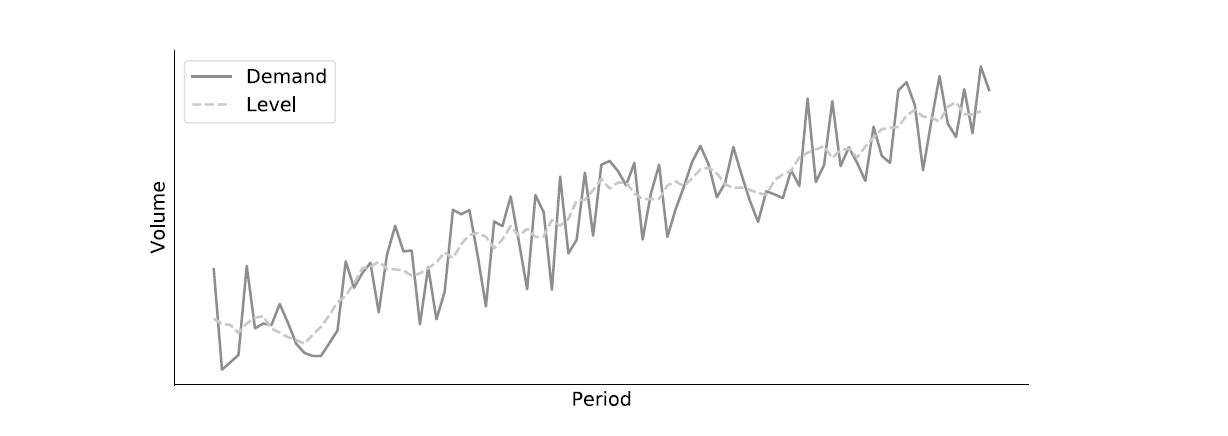

Rispetto ai modelli NAIVE o al MOVING AVERAGE le differenze sono:
- Il peso assegnato ai periodi nell'effettuare la previsione **DECRESCE ESPONENZIALMENTE**. Per questo gli ultimi periodi sono pesati maggiormente rispetto ai periodi più indietro nel tempo
- Resiste meglio ad **outliers** e **rumore**

Il modello è il seguente:

$f_{t} = \alpha d_{t-1} + (1-\alpha) f_{t-1}$

$f_{t} =\alpha d_{t-1} + \alpha(1-\alpha)d_{t-2} + (1-\alpha)^{2}f_{t-2}$

$f_{t} =\alpha d_{t-1} + \alpha(1-\alpha)d_{t-2}+ \alpha(1-\alpha)^{2}d_{t-3} + \alpha(1-\alpha)^{3}d_{t-4} + ... $

- $\alpha$ grande --> alto LEARNING RATE --> predirigo il valore nuovo $d_{t-1}$ per computare la forecast --> MODELLO INNOVATIVO più sensibile ad OUTLIERS e RUMORE
- $\alpha$ piccolo --> basso LEARNING RATE --> predirigo il valore più vecchio $f_{t-1}$ per computare la forecast --> MODELLO CONSERVATIVO meno sensibile ad OUTLIERS e RUMORE

Una volta esautiti i periodi per fare la forecast e quindi una volta computata l'ultima forecast disponibile, non resta che prendere l'ultima previsione e ricopiarla su tutti i periodi futuri a venire:

$f_{t > t^{*}} = f_{t^{*}}$

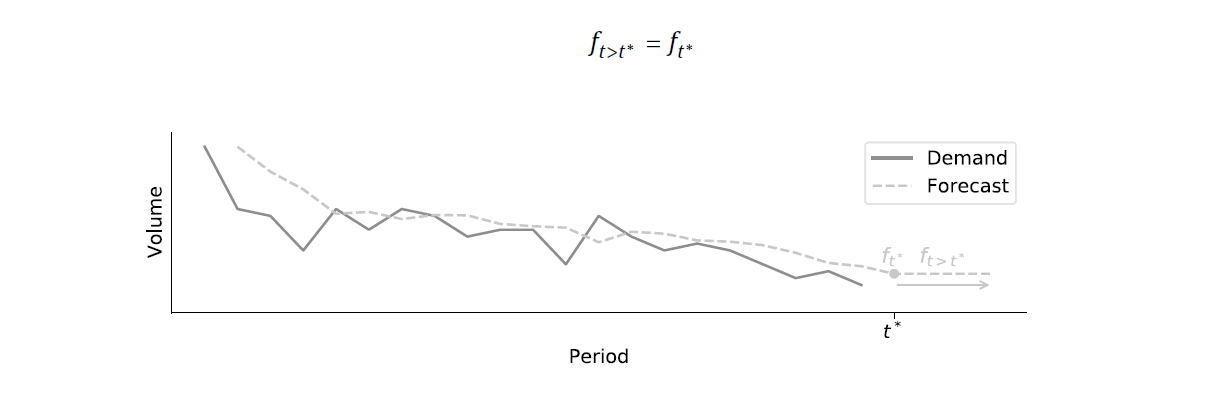

Per quanto riguarda l'inizializzazione abbiamo 2 modi:
- Simple Inizialization 
- Average Inizialization 

## Simple Inizialization

Metto la prima forecast, ovvero quella al tempo 0, è pari al primo periodo osservato:

$f_{0} = d_{0}$

$f_{1} = \alpha d_{0} + (1-\alpha) f_{0} = d_{0}$

$f_{2} = \alpha d_{1} + (1-\alpha) f_{1} = \alpha d_{1} + (1-\alpha) d_{0}$

$f_{3} = \alpha d_{2} + \alpha (1-\alpha) d_{1} + (1-\alpha)^{2} d_{0}$

$f_{4} = \alpha d_{3} + \alpha(1-\alpha) d_{2} + \alpha(1-\alpha)^{2} d_{1} + (1-\alpha)^{3} d_{0}$

$...$

$f_{t+1} = \alpha d_{t} + \alpha(1-\alpha) d_{t-1} + \alpha(1-\alpha)^{2}d_{t-2} + \alpha(1-\alpha)^{3} d_{t-3} + ... + (1-\alpha)^{t} d_{0}$


## Average Inizialization

La prima forecast, ovvero quella al tempo 0, è pari alla media delle prime n-occorrenze

$f_{0} = \frac{1}{n}\sum\limits_{t=0}^{n}d_{t}$    

Se la media viene fatta scegliendo un **numero di osservazioni n** troppo elevato, si va incontro al problema del **DATA LEAKAGE**, ovvero sto iniziando la forecast al tempo 0, considerando periodi di domanda futuri che io in teoria al tempo 0 non dovrei conoscere.

In altre parole sto dando al mio modello pezzi di informazione futura che non dovrei dargli. Ad esempio è come se chiedessi al modello di darmi la forecast dei prossimi 10 periodi, considerando che la domanda dei prossimi 10 periosi è tot. Quindi è probabile che se nell'inizializzare i parametri dò troppe informazioni future, facendo quindi DATA LEAKAGE, sto cadendo in **OVERFITTING**: la previsione sarà buona sui periodi iniziali overfittati ma tale accuratezza non sarà replicabile man mano che si procede nel futuro.

Come regola sperimentale quindi si può scegliere $n = \frac{1}{\alpha}$
- $\alpha$ **ELEVATO** --> inizializzazione brusca di $f_{0}$ su pochi periodi iniziali. Infatti con $\alpha$ alto il modello è **REATTIVO** ma non resiste bene ad OUTLIERS e RUMORE
- $\alpha$ **BASSO** --> inizializzazione smooth su tanti periodi iniziali. Infatti con $\alpha$ basso il modello è **LENTO** in reazione, ma resiste meglio ad OUTLIERS e RUMORE

Dopo negli esempi provare a cambiare i valori di $\alpha$ per vedere come reagisce la previsione. In ogni caso **valori accettabili di $\alpha$ sono TRA 0.05 e 0.5**. Se $1alpha$ > 0.5, significa che sto dando troppa importanza ai periodi nuovi e non allo storico di domanda, facendo pensare che qualcosa non va col modello.

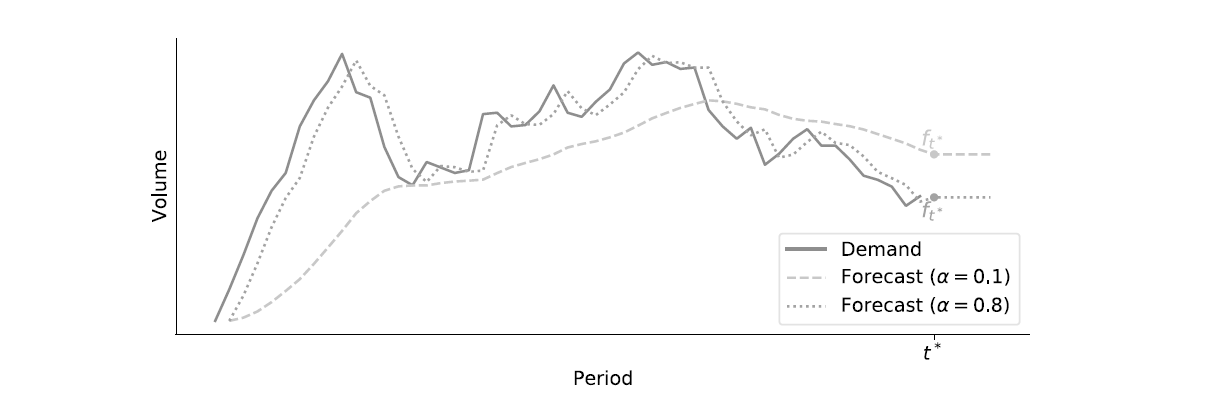

## Perché si chiama Simple Exponential Smoothing ?

Perché i pesi decrescono con funzione esponenziale $y = \alpha(1-\alpha)^{x}$

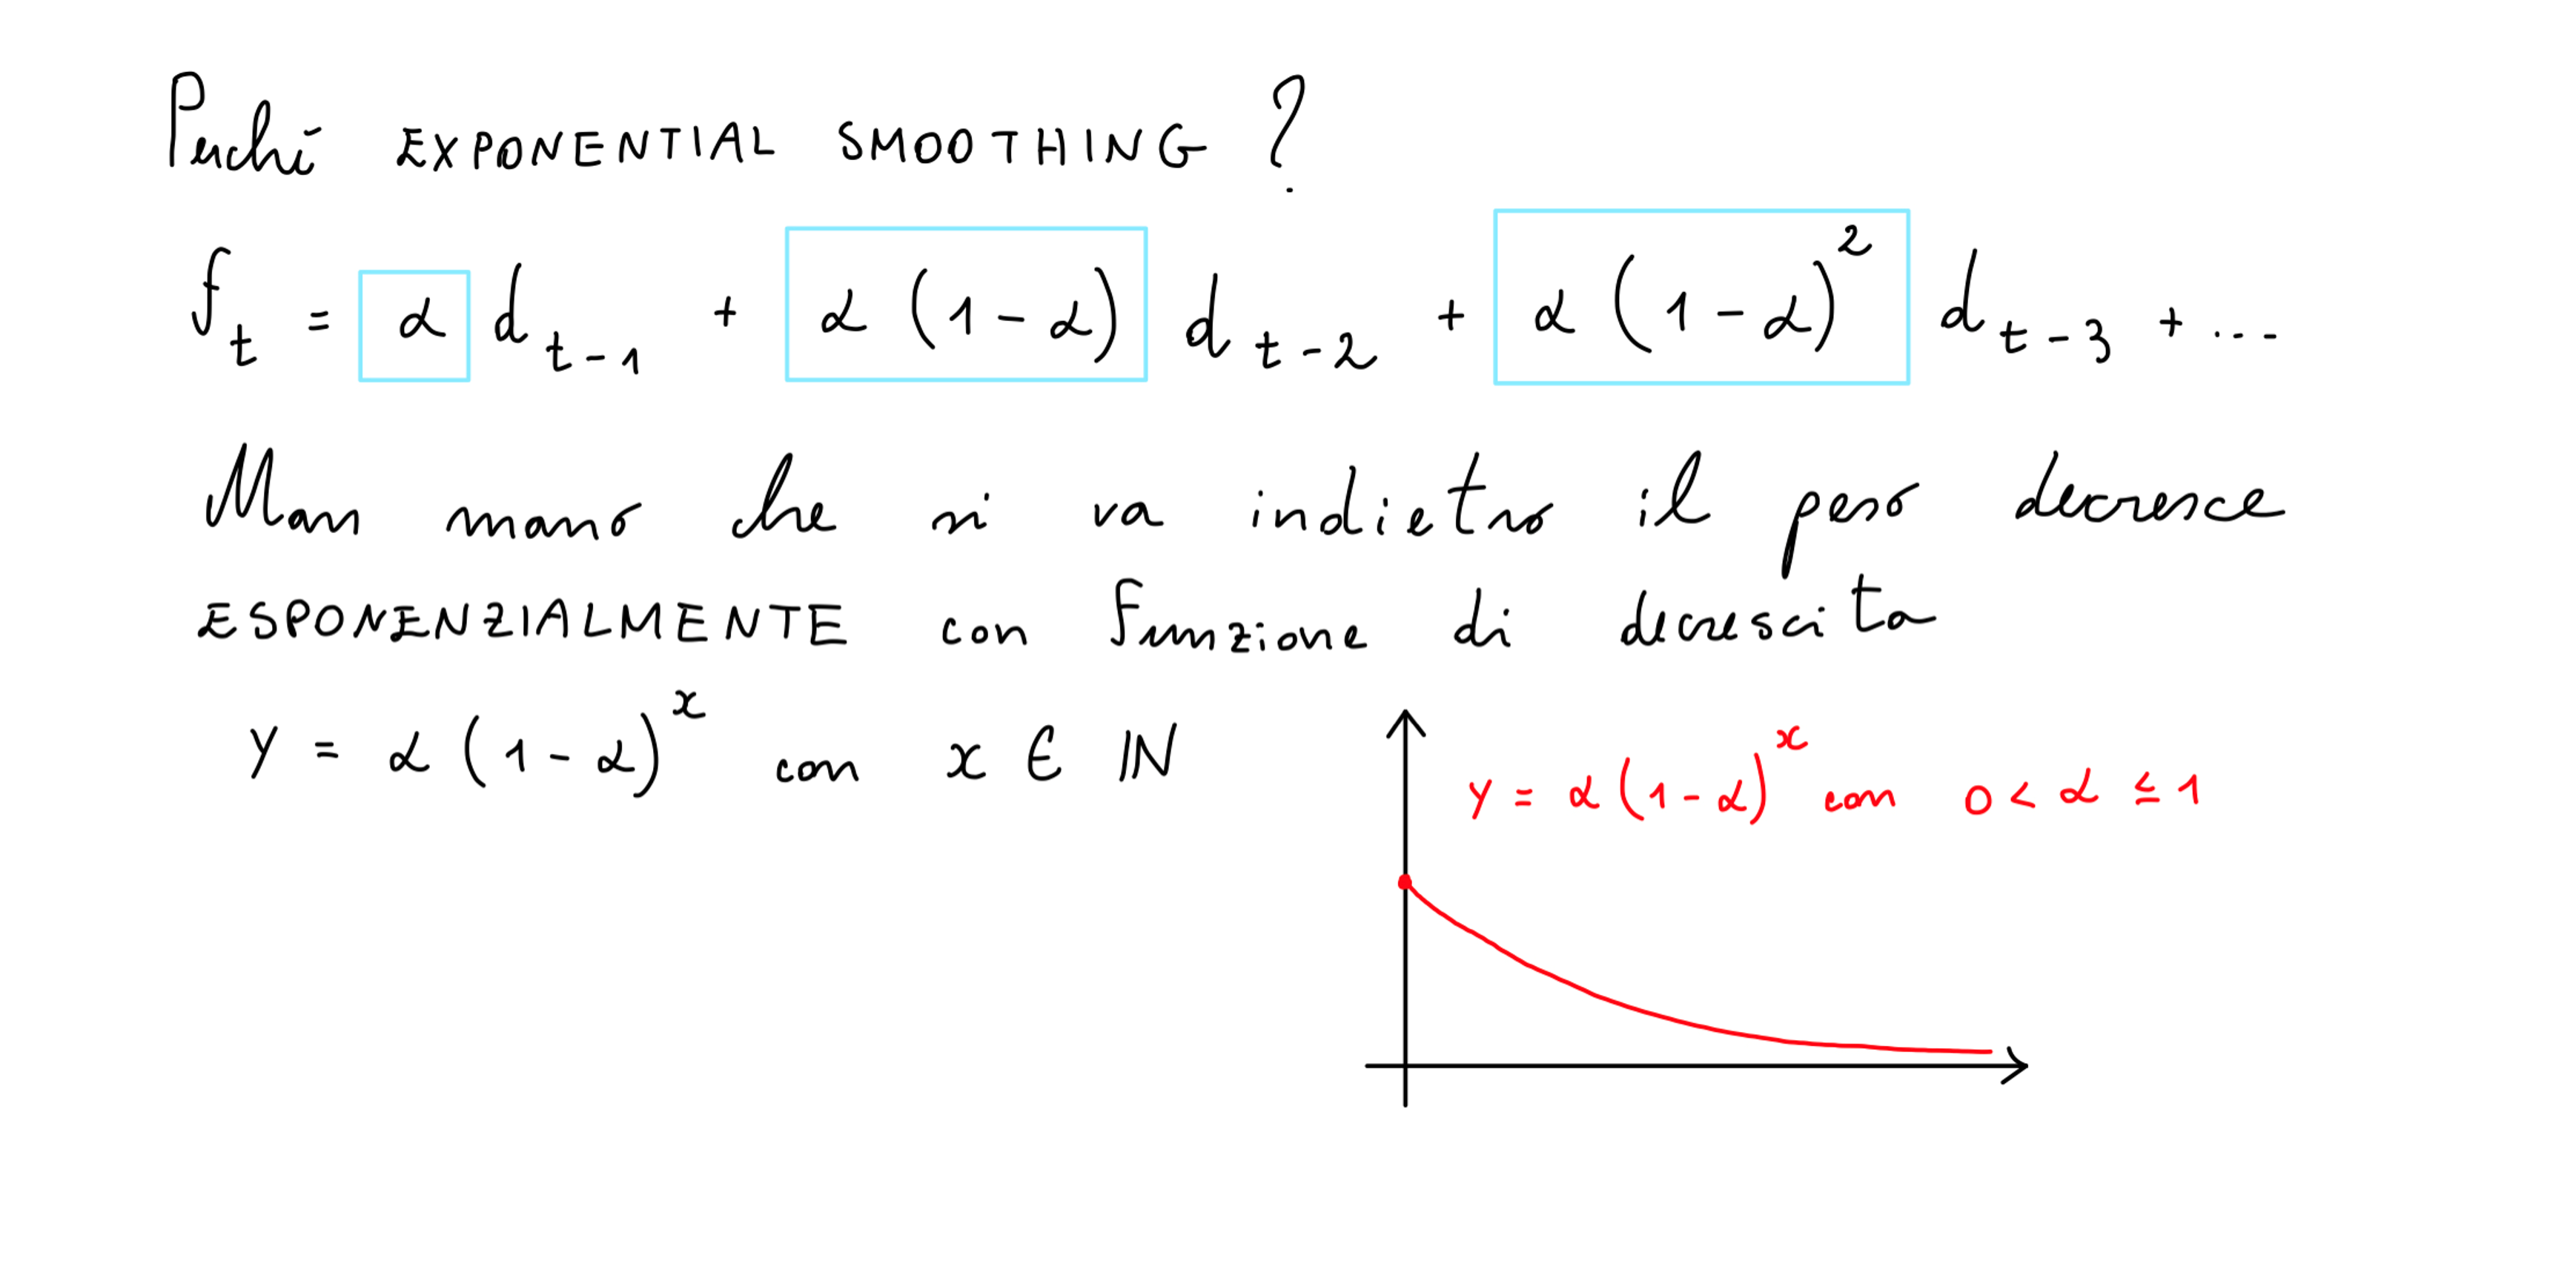

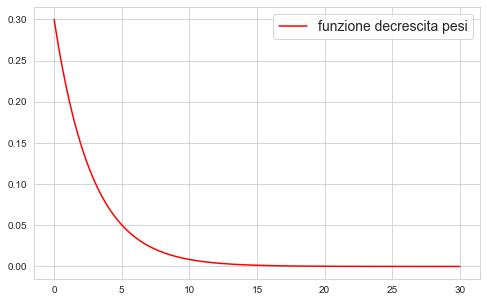

In [2]:
alpha = 0.3
x = np.arange(0, 30, 0.01)
y = alpha*(1-alpha)**x

plt.figure(figsize = [8, 5])
plt.plot(x, y, color = 'red', label = 'funzione decrescita pesi')
plt.legend(fontsize = 14)
plt.show()

## Limitazioni del Simple Exponential Smoothing

Le limitazioni sono:
- Non riconosce né proietta il **trend**. Per quello serve il **Double Exponential Smoothing**
- Non riconosce la **stagionalità**. per quello serve il **Triple Exponential Smoothing**
- Non gestisce **variabili esterne**, ma solo la serie stessa. Per quello serve il **Machine Learning**

## Funzione

In [3]:
def Simple_Exp_Smooth(d, extra_periods = 4, alpha = 0.3, init = 'simple'):
    
    
    # Creo array
    k = len(d)
    d = np.append(d, [np.nan]*extra_periods) # domanda
    f = np.full(k + extra_periods, np.nan) # forecast
    
    
    # SCELTA MODALITA' di INIZIALIZZAZIONE
    if (init == 'simple'):
        f[0] = d[0]
    elif(init == 'avg'):
        n = math.floor(1/alpha)
        f[0] = d[0:n].mean()
    else:
        print('Scegli una modalità di inizializzazione consona')
        return(None)
    
    
    # RIEMPIO
    for t in range(1, k+1):
        f[t] = alpha*d[t-1] + (1-alpha)*f[t-1]
    
    f[t+1:] = f[t] # Riempio da k+1 in fondo. Alla fine del for t vale k
    
    
    #Creo df
    df = pd.DataFrame({'Demand': d,
                       'Forecast':f, 
                       'Error': d-f})
    
    
    return(df)

In [4]:
#VERSIONE_2

def Simple_Exp_Smooth_Variant(d, extra_periods, alpha):
    
    # Creo array
    k = len(d)
    d = np.append(d, [np.nan]*extra_periods) # domanda
    f = np.full(k + extra_periods, np.nan) # forecast
    
    #Inizializzo la prima forecast
    f[1] = d[0]
    
    for t in range(2, k+1): # n incluso - k escluso
        f[t] = alpha*d[t-1] + (1-alpha)*f[t-1]
    
    for t in range(k+1, k+extra_periods):
        f[t] = f[t-1]
    
    #Creo df
    df = pd.DataFrame({'Demand': d,
                       'Forecast':f, 
                       'Error': d-f})
    
    return(df)

In [5]:
d = [28, 19, 18, 13, 19, 16, 19, 18, 13, 16, 16, 11, 18, 15, 13, 15, 13, 11, 13, 10, 12]

In [6]:
df = Simple_Exp_Smooth(d, extra_periods = 4, alpha = 0.3, init = 'simple')
df.head()

Demand  Forecast   Error
0    28.0    28.000   0.000
1    19.0    28.000  -9.000
2    18.0    25.300  -7.300
3    13.0    23.110 -10.110
4    19.0    20.077  -1.077

In [7]:
df_variant = Simple_Exp_Smooth_Variant(d, extra_periods = 4, alpha = 0.3 )
df_variant.head()

Demand  Forecast   Error
0    28.0       NaN     NaN
1    19.0    28.000  -9.000
2    18.0    25.300  -7.300
3    13.0    23.110 -10.110
4    19.0    20.077  -1.077

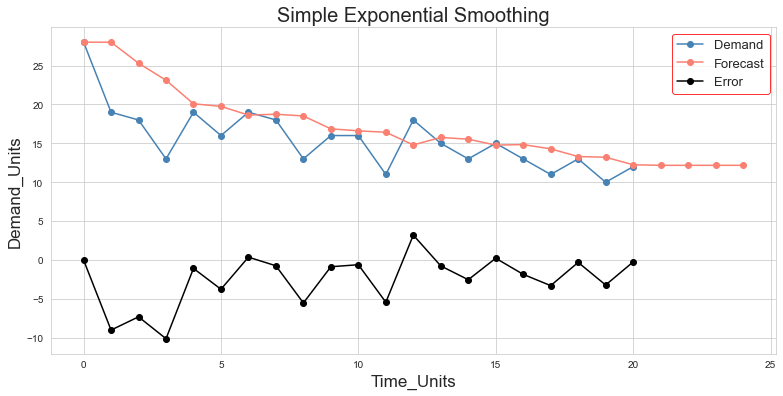

In [8]:
# Plot

fig, ax = plt.subplots(figsize = (13, 6))

ax.plot(df['Demand'], marker = 'o', color = 'steelblue', label = 'Demand')
ax.plot(df['Forecast'], marker = 'o', color = 'salmon', label = 'Forecast')
ax.plot(df['Error'], marker = 'o', color = 'black', label = 'Error')

#ax.plot(df_variant['Demand'], color = 'steelblue', label = 'Demand')
#ax.plot(df_variant['Forecast'], color = 'salmon', label = 'Forecast')
#ax.plot(df_variant['Error'], color = 'black', label = 'Error')

ax.set_xlabel('Time_Units', fontsize = 17)
ax.set_ylabel('Demand_Units', fontsize = 17)

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)

ax.set_title('Simple Exponential Smoothing', fontsize = 20)

plt.show()

# Air Passengers

In [9]:
d = pd.read_csv(r'C:\Users\peria\Desktop\DATA SCIENCE\TIME SERIES\Data Science For Supply Chain Forecasting\AirPassengers.csv')
d['Month'] = pd.to_datetime(d['Month'], yearfirst = True)
d.set_index(d['Month'], inplace = True)
d.drop(columns = ['Month'], inplace = True)
d.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

In [10]:
df = Simple_Exp_Smooth(d.values, extra_periods = 4, alpha = 0.4, init = 'simple')


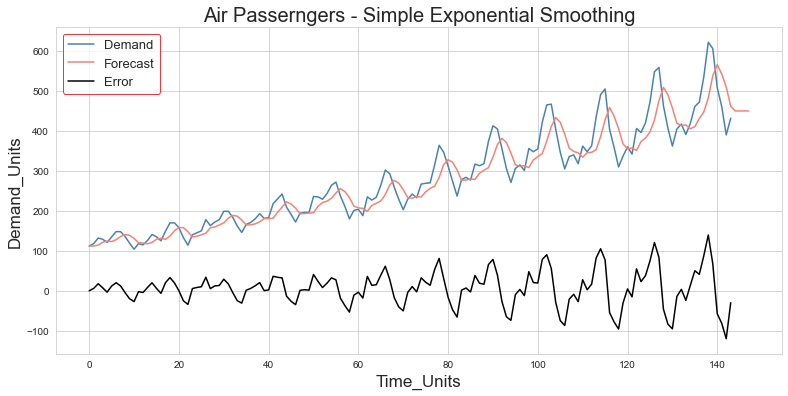

In [11]:
# Plot

fig, ax = plt.subplots(figsize = (13, 6))

ax.plot(df['Demand'], color = 'steelblue', label = 'Demand')
ax.plot(df['Forecast'], color = 'salmon', label = 'Forecast')
ax.plot(df['Error'], color = 'black', label = 'Error')

ax.set_xlabel('Time_Units', fontsize = 17)
ax.set_ylabel('Demand_Units', fontsize = 17)

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)

ax.set_title('Air Passerngers - Simple Exponential Smoothing', fontsize = 20)

plt.show()

Nell'immagine soprastante si vede chiaramente che nel rumore resta la componente di stagionalità, essendo il metodo solo in grado di catturare il LIVELLO della serie. Inoltre si vede che la previsione che viene fatta è piatta nei periodi di tempo futuri per cui non abbiamo domanda, quindi per adesso il nostro modello è troppo semplice.

## Underfitting

**IMPORTANTE:** nel caso di time series forecasting, se il training è UNDERFITTATO, ovvero se l'accuratezza con cui il nostro modello fitta i dati storici è troppo bassa, sinifica che:
- Il nostro modello è troppo semplice --> complichiamo adesso il Simple Exponential Smoothing
- Il nostro modello deve considerare variabili esogne per essere più accurato --> lo vedremo nel machine learning

In [12]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

# 2) Double Exponential Smoothing

Il **Simple Exponential Smoothing** è un modello troppo semplice per individare e proiettare le componenti di **TREND**.
Ricorda che si definisce **TREND** la **variazione media di livello della serie tra 2 periodi successivi**.
Ricorda che il **LIVELLO** è il valore attorno a cui oscilla la serie. 

Quindi se il LIVELLO della serie cresce o decresce nel tempo, si può calcolare il TREND della serie come media degli incrementi (o decrementi) di LIVELLO tra due osservazioni adiacenti all'interno di un certo lasso temporale.

$incr.livello = \frac{livello_{t} - livello_{t-1}}{t-(t-1)} = livello_{t} - livello_{t-1}$

Nel Double Expnential Smoothing al tempo t faccio la forecast per il tempo t+1 considerando:
- La **domanda al tempo t** --> valore innovativo 
- La **forecast al tempo t-1** --> valore conservativo

La **forcast dal periodo t al periodo t+1** in questo modello è: $f_{t+1} = a_{t} + b_{t}$

Questo ragionamento entra in gioco:
- Nella stima del LIVELLO $a$ --> pesato con $\alpha$
- Nella stima del TREND $b$ --> pesato con $\beta$

L'approccio per computare la **forecast** per il periodo t+1 consiste in:
1) Stimare il livello al periodo t --> $a_{t}$

2) Utilizzare il livello stimato $a_{t}$ per computare il trend $b_{t}$

3) Sommare $a_{t}$ e $b_{t}$ per trovare $f_{t+1}$ = $a_{t} + b_{t}$

4) Ricalcolare il nuovo livello al periodo t+1 -->$a_{t+1}$

E così via...

## Stima del livello $a$
Il **LIVELLO** al periodo t è la combinazione convessa di:
- Domanda al periodo t --> $d_{t}$ --> valore innovativo pesato con $\alpha$
- Forecast computata al periodo precedente sommando **LIVELLO** e **TREND** del periodo precedente $a_{t-1} + b_{t-1}$ --> valore innovativo pesato con $1-\alpha$

$a_{t} = \alpha d_{t} + (1-\alpha) (a_{t-1} + b_{t-1})$

## Stimare il trend $b$

Prima di tutto è necessario vedere il **TREND** come **inclinazione della retta** che partendo dal livello $a_{t-1}$ porta alla forecast del periodo t:

$f_{t} = a_{t-1} + b_{t-1}(t-(t-1)) = a_{t-1} + b_{t-1}$


Sfrutto il  **nuovo LIVELLO** (ovvero $a_{t}$) appena calcolato per aggiustare il **TREND precedente** (ovvero $b_{t-1}$).

Il **TREND** al periodo t è la combinazione convessa di:
- Nuova inclinazione che da $a_{t-1}$ mi porta al $a_{t}$ (aggiornato al passo precedente) --> valore innovativo pesato con $\beta$
- Trend al periodo t-1 --> $b_{t-1}$ --> valore conservativo pesato con $1-\beta$

$b_{t} = \beta \frac{a_{t} - a_{t-1}}{t-(t-1)} + (1-\beta)b_{t-1}$ 

$b_{t} = \beta (a_{t} - a_{t-1}) + (1-\beta)b_{t-1}$

## Forecast
Se siamo al periodo t, per ottenere la forecast del periodo t+1, è sufficiente prendere il livello $a_{t}$ e da lì sommarci il trend $b_{t}$ ottenendo $f_{t+1}$

$f_{t+1}$ = $a_{t}$ + $b_{t}$

## Intuizione grafica

Per capire davvero questo modello, è necessario vedere l'intuizione grafica. Si tratta infatti di un concetto semplice: parto da un livello, che sarebbe l'intercetta della mia retta, e vado verso la forecast sommando al livello il trend, che può essere visto come l'inclinazione della retta.

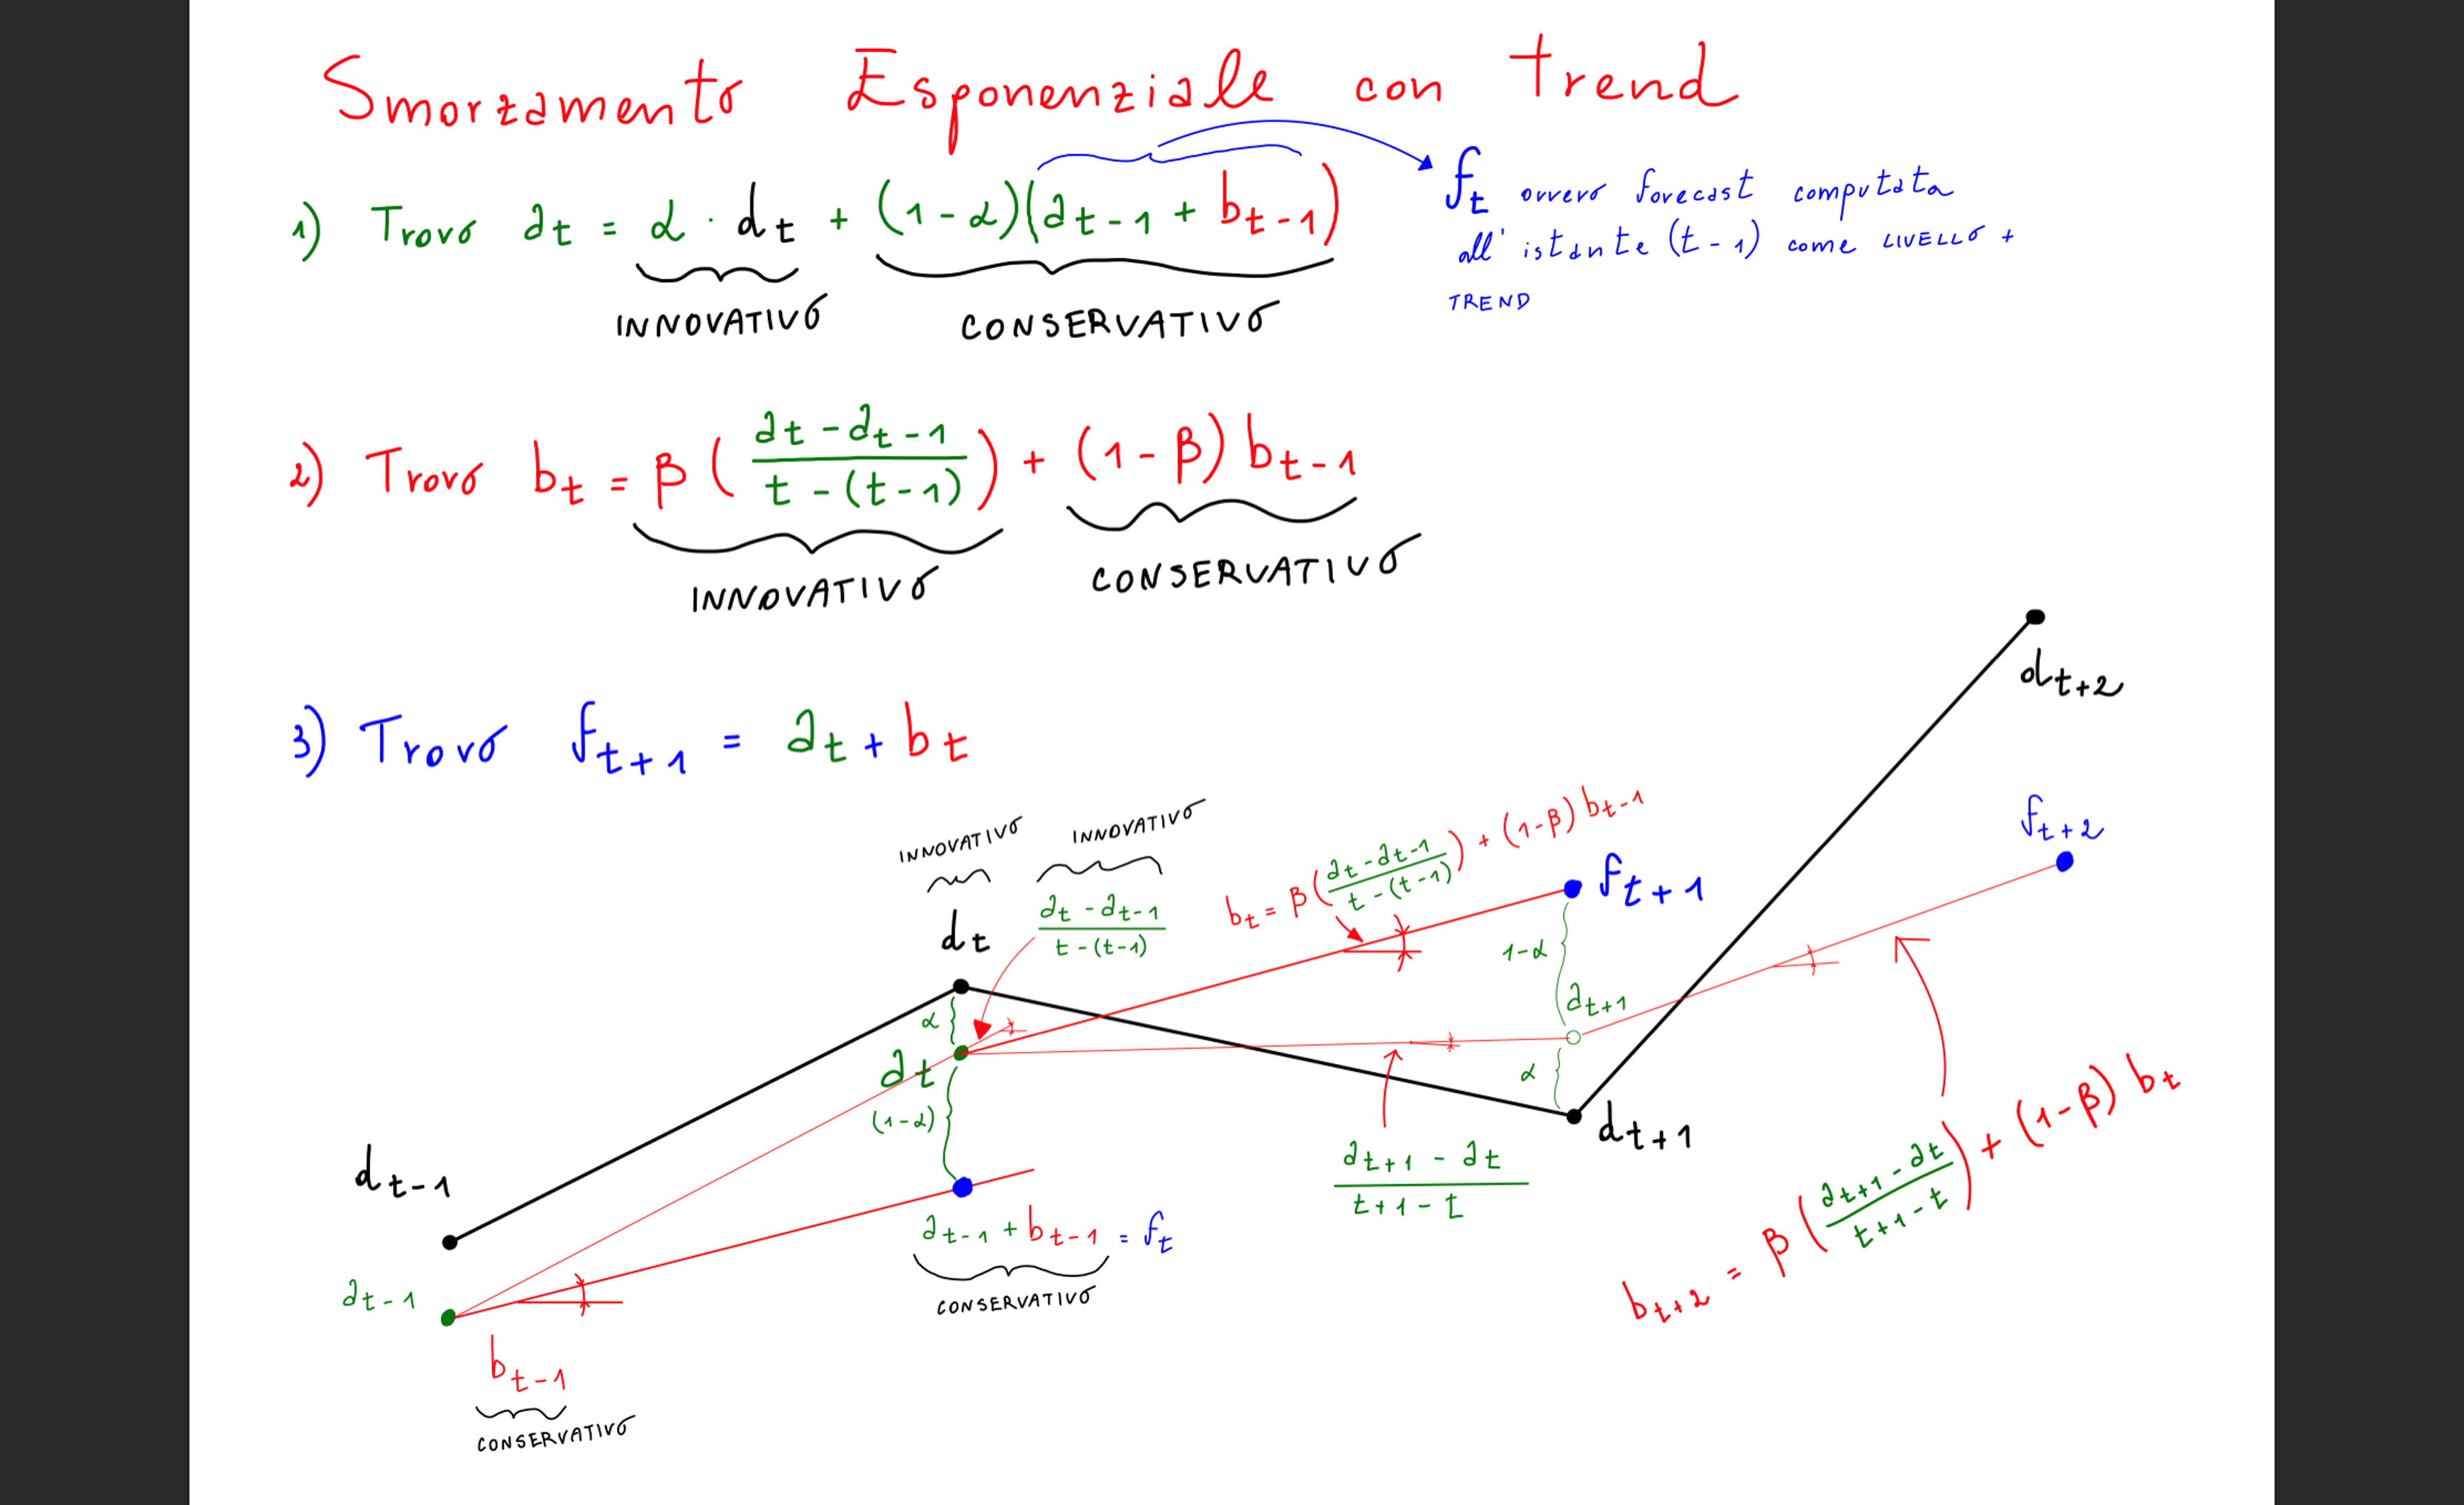

## Generalizzazione al periodo $t+\lambda$

Avendo ben presente il modello riportato qui sopra, si può concludere che se adesso siamo al tempo t, possiamo computare:

$a_{t} = \alpha d_{t} + (1-\alpha) (a_{t-1} + b_{t-1})$

$b_{t} = \beta (a_{t} - a_{t-1}) + (1-\beta) b_{t-1}$

$f_{t+1} = a_{t} + b_{t}$

$f_{t+2} = a_{t} + 2 b_{t}$

E in generale se guardo al periodo t + $\lambda$

$f_{t+\lambda} = a_{t} + \lambda b_{t}$

Ovviamente questa proiezione è una retta che non viene aggiustata tra $t$ e  $t+\lambda$, quindi non sarà appropriata. Tuttavia si noti che mentre sia nel **Moving Average** che nella **Simple Exponential Smoothing** la forecast era piatta per periodi futuri per cui mancava domanda, qui viene almeno riconosciuto e proiettato il trend.

## Inizializzazione del modello

Anche qui ci sono alcuni modi diversi per inizializzare il modello:
- **Simple inizialization**
- **Linear regression** sui primi periodi

## Simple Inizialization

Il livello al tempo t=0 viene preso pari a $d_{0}$

$a_{0} = d_{0}$

Il trend al tempo t=0 viene preso pari alla differenza tra $d_{1}$ e $d_{0}$. Questo permette di avere anche POCO DATA LEAKAGE in quanto nello stimare un parametro al periodo 0, ovvero $b_{0}$, considero solo un'osservazione futura che non dovrei avere, ovvero $d_{1}$.

$b_{0} = d_{1}-d_{0}$

Da ciò ne consegue che:

$f_{1} = a_{0} + b_{0} = d_{1}$

Quindi scegliendo questo tipo di inizializzazione, viene automaticamente che $f_{1} = d_{1}$.

A tal fine se si deve comparare l'errore prodotto da questo modello con l'errore prodotto da un altro modello, è opportuno levare $f_{1}$ dalla metrica di errore onde evitare che venga artificialmente più bassa, a meno che il dataset non sia così elevato da rendere questa piccolezza trascurabile.

## Linear Regression

Viene fatta una regressione sulle prime osservazioni.
Attenzione che qui si rischia ancora una volta il **DATA LEAKAGE**. Una buona regola è quella di prendere **valori bassi come 3 o 5**, altrimenti considerare un valore **proporzionale alla media di $\frac{1}{\alpha}$ e $\frac{1}{\beta}$**.

In [13]:
d = [28, 19, 18, 13, 19, 16, 19, 18, 13, 16, 16, 11, 18, 15, 13, 15, 13, 11, 13, 10, 12]

#Fitto una retta di regressione sulle prime n_oss osservazioni
n_oss = 5
coefficiente_angolare = np.polyfit(np.arange(0, n_oss, 1), d[0:n_oss], deg = 1)[0]
intercetta = np.polyfit(np.arange(0, n_oss, 1), d[0:n_oss], deg = 1)[1]

(coefficiente_angolare, intercetta)

(-2.4, 24.19999999999999)

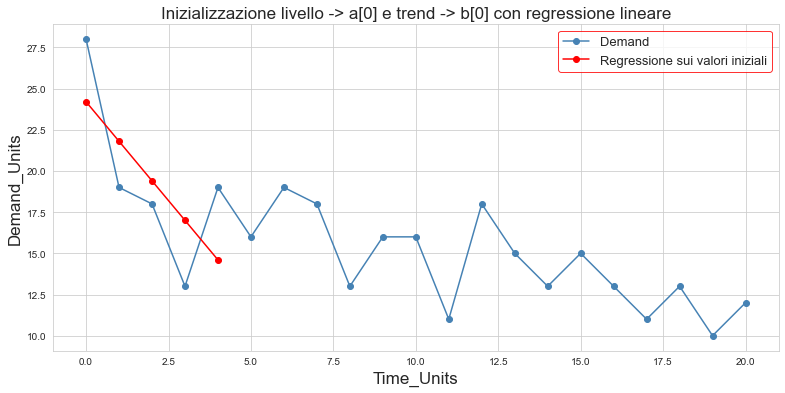

In [14]:
# Plot

fig, ax = plt.subplots(figsize = (13, 6))

ax.plot(np.arange(0, len(d), 1), d, 'o-', color = 'steelblue', label = 'Demand')
ax.plot(np.arange(0, n_oss, 1), np.arange(0, n_oss, 1)*coefficiente_angolare +  intercetta, 'o-', color = 'red', 
        label = 'Regressione sui valori iniziali')

ax.set_xlabel('Time_Units', fontsize = 17)
ax.set_ylabel('Demand_Units', fontsize = 17)

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)

ax.set_title('Inizializzazione livello -> a[0] e trend -> b[0] con regressione lineare', fontsize = 17)

plt.show()

In [15]:
def Double_Exp_Smooth(d, extra_periods = 1, alpha = 0.4, beta = 0.4, init = 'simple'):
    
    # Creo gli array 
    k = len(d)
    d = np.append(d, [np.nan]*extra_periods) # domanda
    
    a = np.full(k + extra_periods, np.nan) # level
    b = np.full(k + extra_periods, np.nan) # trend
    
    f = np.full(k + extra_periods, np.nan) # forecast
    
    
    # Inizializzo
    if init == 'simple':
        a[0] = d[0]
        b[0] = d[1] - d[0] # data leakage
    elif init == 'reg':
        n_oss_reg = 5 # Scelgo le prime 5 osservazioni per stimare i parametri iniziali a[0] e b[0] --> data leakage
        b[0] = np.polyfit(np.arange(0, n_oss, 1), d[0:n_oss], deg = 1)[0]
        a[0] = np.polyfit(np.arange(0, n_oss, 1), d[0:n_oss], deg = 1)[1]
    else:
        print('Scegli una modalità di inizializzazione consona')
        return(None)
    
    
    # Riempio
    for t in range(1, k):
        f[t] = a[t-1] + b[t-1] # 1) Computo la forecast
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1] + b[t-1]) # 2) Aggiusto il livello a[t] in base alla f[t] e d[t]
        b[t] = beta*(a[t] - a[t-1]) + (1-beta)*b[t-1] # 3) Aggiusto il trend sulla base di a[t] appena aggiornato
    
    # Uscito dal for qui di sopra t vale k-1, quindi non ho ancora fatto previsioni per periodi 
    # sui quali non ho la domanda. Le faccio qui cambiando il modo di calcolare a[t] e quindi b[t]
    for t in range(k, k + extra_periods):
        f[t] = a[t-1] + b[t-1] # 1) Computo la forecast
        a[t] = f[t] # 2) Il livello equivale alla forecast e cresce di ogni periodo di un valore pari al trend b[t]
        b[t] = b[t-1] # 3) Il trend è costante e incrementa il livello di un valore costante --> proiezione lineare
        
        
    #Creo df
    df = pd.DataFrame({'Demand': d,
                       'Forecast':f,
                       'Level': a,
                       'Trend':b,
                       'Error': d-f})
    
    return(df)

In [16]:
d = [28, 19, 18, 13, 19, 16, 19, 18, 13, 16, 16, 11, 18, 15, 13, 15, 13, 11, 13, 10, 12]

In [17]:
df = Double_Exp_Smooth(d, extra_periods = 5, alpha = 0.4, beta = 0.4, init = 'reg')
df.head()

Demand   Forecast      Level     Trend     Error
0    28.0        NaN  24.200000 -2.400000       NaN
1    19.0  21.800000  20.680000 -2.848000 -2.800000
2    18.0  17.832000  17.899200 -2.821120  0.168000
3    13.0  15.078080  14.246848 -3.153613 -2.078080
4    19.0  11.093235  14.255941 -1.888530  7.906765

In [18]:
df.tail(10)

Demand   Forecast      Level     Trend     Error
16    13.0  14.329366  13.797619 -0.315381 -1.329366
17    11.0  13.482238  12.489343 -0.712539 -2.482238
18    13.0  11.776804  12.266082 -0.516828  1.223196
19    10.0  11.749255  11.049553 -0.796708 -1.749255
20    12.0  10.252844  10.951707 -0.517164  1.747156
21     NaN  10.434543  10.434543 -0.517164       NaN
22     NaN   9.917379   9.917379 -0.517164       NaN
23     NaN   9.400216   9.400216 -0.517164       NaN
24     NaN   8.883052   8.883052 -0.517164       NaN
25     NaN   8.365889   8.365889 -0.517164       NaN

La cosa che rende lo Smorzamento Esponenziale una buona tecnica è la semplicità e la possibilità di decomporre la serie isolandone le componenti di livello e trend (poi nel Triple Exponential Smoothing anche di stagionalità). Ecco perché sono complementari al machine learning.

Se per fare la forecast su un codice devo impostare alti valori di $\alpha$ e $\beta$, significa che la previsione di quel codice sarà soggetta a fluttuazioni locali e quindi quel codice non è molto smooth.

Viceversa un codice prevedibile con bassi valori di $\alpha$ e $\beta$ è più probabile che sia smooth.

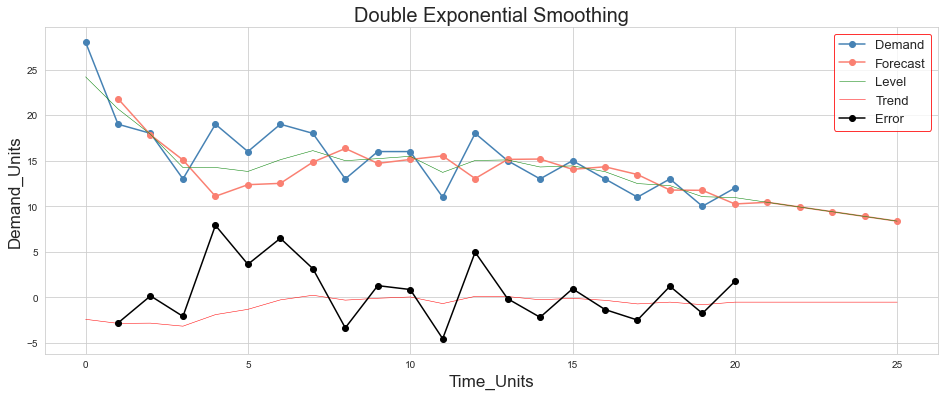

In [19]:
# Plot

fig, ax = plt.subplots(figsize = (16, 6))

ax.plot(df['Demand'], marker = 'o', color = 'steelblue', label = 'Demand')
ax.plot(df['Forecast'], marker = 'o', color = 'salmon', label = 'Forecast')
ax.plot(df['Level'], color = 'green', label = 'Level', linewidth = 0.5)
ax.plot(df['Trend'], color = 'red', label = 'Trend', linewidth = 0.5)
ax.plot(df['Error'], marker = 'o', color = 'black', label = 'Error')


ax.set_xlabel('Time_Units', fontsize = 17)
ax.set_ylabel('Demand_Units', fontsize = 17)

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)

ax.set_title('Double Exponential Smoothing', fontsize = 20)

plt.show()

## Interessante relazione tra TREND $b_{t}$ ed ERRORE $e_{t}$

Per come è costruito il metodo viene fatta una forecast:

$f_{t} = a_{t-1} + b_{t-1}$

E sulla base di questa viene calcolato l'errore rispetto alla domanda $d_{t}$. Sulla base dell'errore viene poi fatto l'update della nuova previsione:
- $f_{t} < d_{t}$: la FORECAST sottostima la DOMANDA, allora $b_{t}$ AUMENTA
- $f_{t} > d_{t}$: la FORECAST sovrastima la DOMANDA, allora $b_{t}$ DIMINUISCE

Questo perché:

$b_{t} = \beta(a_{t} - a_{t-1}) + (1-\beta)b_{t-1}$

$a_{t} = \alpha d_{t} + (1-\alpha)f_{t} = f_{t} + \alpha(d_{t}-f_{t}) = f_{t} + \alpha e_{t}$

In pratica è come se il modello imparasse dai suoi errori.

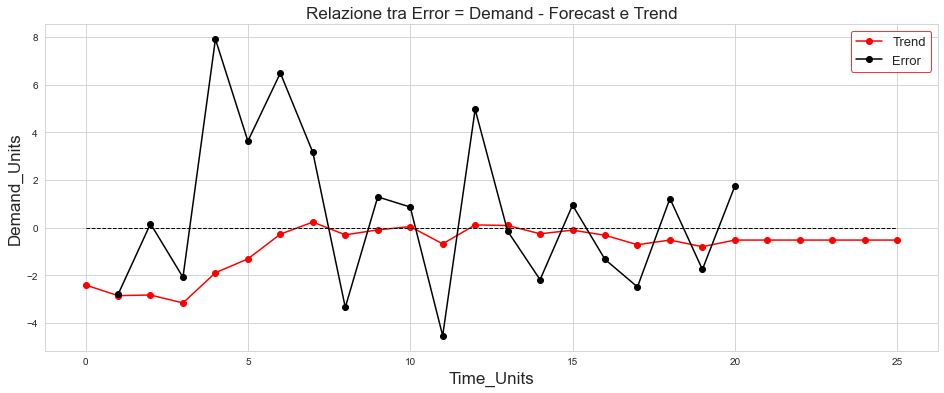

In [20]:
# Plot

fig, ax = plt.subplots(figsize = (16, 6))

ax.plot(df['Trend'], marker = 'o', color = 'red', label = 'Trend')
ax.plot(df['Error'], marker = 'o', color = 'black', label = 'Error')
ax.plot([0, len(df)-1], np.full(2, 0), linestyle = '--', linewidth = 1, color = 'black')
ax.set_xlabel('Time_Units', fontsize = 17)
ax.set_ylabel('Demand_Units', fontsize = 17)
ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)
ax.set_title('Relazione tra Error = Demand - Forecast e Trend', fontsize = 17)

plt.show()

A questo punto la tentazione potrebbe essere quella di fissare un **alto valore di $\alpha$ e $\beta$** in modo che il modello impari più velocemente, ma questo non fa che rendere la previsione molto più oscillante e sensibile a rumore e outliers, come mostrato nel grafico qui sotto:

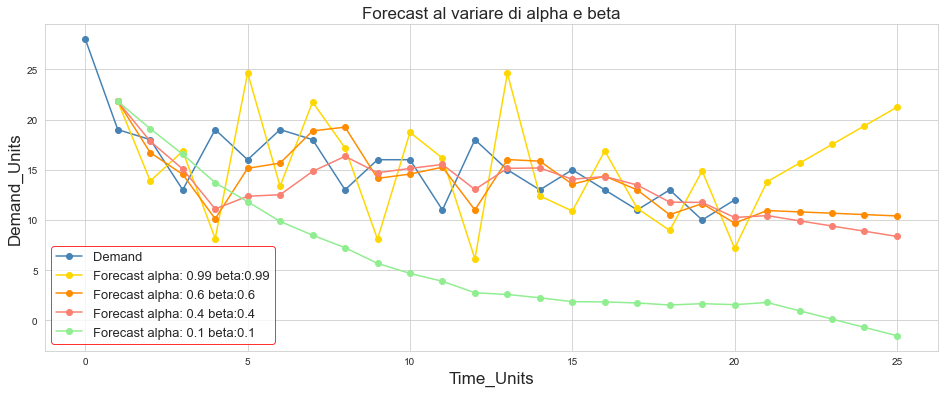

In [21]:
# Plot

fig, ax = plt.subplots(figsize = (16, 6))

dict_params = {0.99: 'gold', 0.6:'darkorange', 0.4:'salmon', 0.1:'lightgreen'}

ax.plot(df['Demand'], marker = 'o', color = 'steelblue', label = 'Demand')
    

for params in dict_params.keys():
    df = Double_Exp_Smooth(d, extra_periods = 5, alpha = params, beta = params, init = 'reg')
    ax.plot(df['Forecast'], marker = 'o', color = dict_params[params], 
            label = 'Forecast alpha: ' + str(params) + ' beta:' + str(params))
    
ax.set_xlabel('Time_Units', fontsize = 17)
ax.set_ylabel('Demand_Units', fontsize = 17)
ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)
ax.set_title('Forecast al variare di alpha e beta', fontsize = 17)

plt.show()

# Air Passengers

Questa serie ha sia trend che stagionalità, quindi il Double_Exponential_Smoothing che riconosce solo il livello e il trend non basta a modellarla correttamente. Comunque ci si può provare.

In [22]:
d = pd.read_csv(r'C:\Users\peria\Desktop\DATA SCIENCE\TIME SERIES\Data Science For Supply Chain Forecasting\AirPassengers.csv')
d['Month'] = pd.to_datetime(d['Month'], yearfirst = True)
d.set_index(d['Month'], inplace = True)
d.drop(columns = ['Month'], inplace = True)
d.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

In [23]:
df = Double_Exp_Smooth(d, extra_periods = 4, alpha = 0.4, beta = 0.4, init = 'simple')
df.head()

Demand  Forecast      Level     Trend    Error
0   112.0       NaN  112.00000  6.000000      NaN
1   118.0  118.0000  118.00000  6.000000   0.0000
2   132.0  124.0000  127.20000  7.280000   8.0000
3   129.0  134.4800  132.28800  6.403200  -5.4800
4   121.0  138.6912  131.61472  3.572608 -17.6912

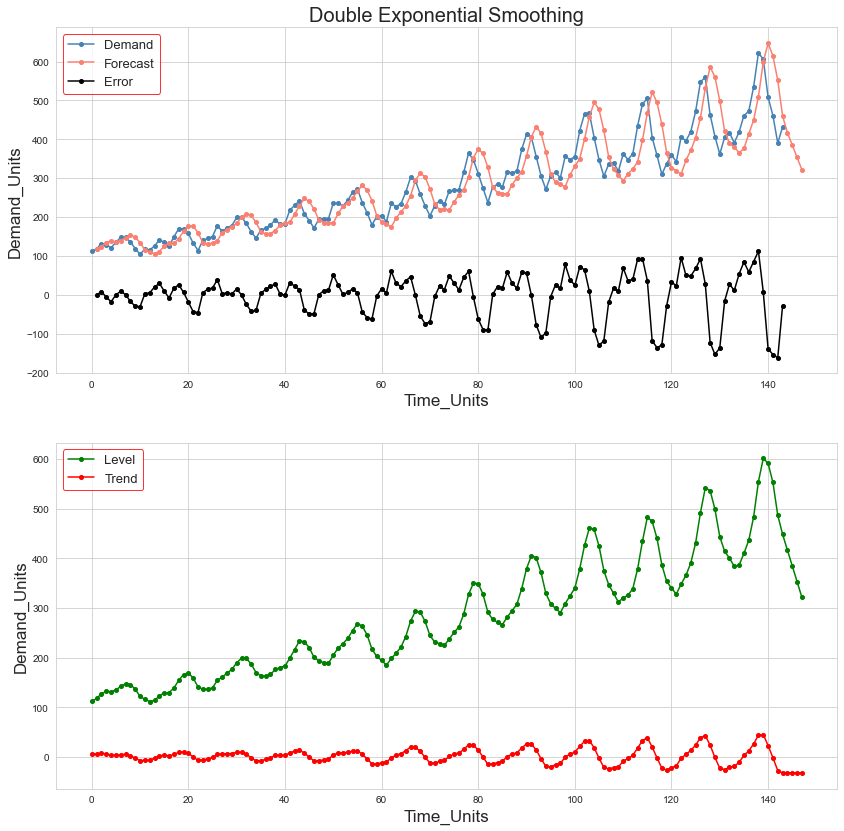

In [24]:
# Plot

fig, ax = plt.subplots(2, figsize = (14, 14))

ax[0].plot(df['Demand'], color = 'steelblue', label = 'Demand', marker = '.', markersize = 8)
ax[0].plot(df['Forecast'], color = 'salmon', label = 'Forecast', marker = '.', markersize = 8)
ax[0].plot(df['Error'], color = 'black', label = 'Error', marker = '.', markersize = 8)

ax[1].plot(df['Level'], color = 'green', label = 'Level', marker = '.', markersize = 8)
ax[1].plot(df['Trend'], color = 'red', label = 'Trend', marker = '.', markersize = 8)


ax[0].set_xlabel('Time_Units', fontsize = 17)
ax[1].set_xlabel('Time_Units', fontsize = 17)
ax[0].set_ylabel('Demand_Units', fontsize = 17)
ax[1].set_ylabel('Demand_Units', fontsize = 17)

ax[0].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')
ax[1].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')

ax[0].set_title('Double Exponential Smoothing', fontsize = 20)

plt.show()

# Ottimizzazione del modello

I parametri $\alpha$ e $\beta$ devono essere scelti considerando una metrica di errore come riferimento, ad esempio il MAE o il MSE. 

**ATTENZIONE:** un errore comune è quello di far variare $\alpha$ e $\beta$ in $[0,1]$. 
Infatti valori di $\alpha$ e $\beta$ sopra $0.6$, indicano che il modello attribuisce un'eccessiva importanza ai valori innovativi della serie e quindi di fatto il modello sta inseguendo continuamente la serie di TRAINING ricadendo sicuramente in OVERFITTING.



In [25]:
def Double_Exp_Smooth_Optimized(d, extra_periods = 5, init = 'simple', metric = 'MAE'):
    
    print(f'Metrica di errore scelta: {metric}')
    metric_list = []
    params_list = []
    df_list = []
    
    for alpha in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
        for beta in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
            
            params_list.append(f'alpha: {alpha} --- beta:{beta}')
            
            df = Double_Exp_Smooth(d, extra_periods = extra_periods, alpha = alpha, beta = beta, init = init)
            df_list.append(df)
            
            MAE = df['Error'].abs().mean()
            MSE = (df['Error']**2).mean()
            
            if (metric == 'MAE'):
                metric_list.append(MAE)
            elif (metric == 'MSE'):
                metric_list.append(MSE)
            else:
                print('Seleziona una metrica adeguata !')
                return np.nan
            
    idx_opt = np.argmin(metric_list)
    print(f'Miglior {metric} raggiunto: {metric_list[idx_opt]}')
    print('Parametri selezionati: ', params_list[idx_opt])
    return(df_list[idx_opt])

In [26]:
d = [28, 19, 18, 13, 19, 16, 19, 18, 13, 16, 16, 11, 18, 15, 13, 15, 13, 11, 13, 10, 12]

df = Double_Exp_Smooth_Optimized(d, extra_periods = 6, init = 'reg', metric = 'MAE')

df.tail()

Metrica di errore scelta: MAE
Miglior MAE raggiunto: 2.567550597060839
Parametri selezionati:  alpha: 0.4 --- beta:0.6


Demand  Forecast     Level     Trend  Error
22     NaN  9.901723  9.901723 -0.440353    NaN
23     NaN  9.461370  9.461370 -0.440353    NaN
24     NaN  9.021017  9.021017 -0.440353    NaN
25     NaN  8.580665  8.580665 -0.440353    NaN
26     NaN  8.140312  8.140312 -0.440353    NaN

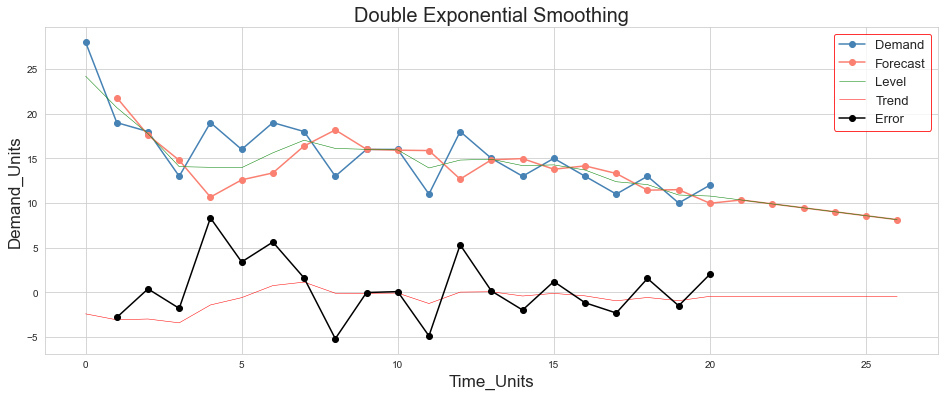

In [27]:
# Plot

fig, ax = plt.subplots(figsize = (16, 6))

ax.plot(df['Demand'], marker = 'o', color = 'steelblue', label = 'Demand')
ax.plot(df['Forecast'], marker = 'o', color = 'salmon', label = 'Forecast')
ax.plot(df['Level'], color = 'green', label = 'Level', linewidth = 0.5)
ax.plot(df['Trend'], color = 'red', label = 'Trend', linewidth = 0.5)
ax.plot(df['Error'], marker = 'o', color = 'black', label = 'Error')


ax.set_xlabel('Time_Units', fontsize = 17)
ax.set_ylabel('Demand_Units', fontsize = 17)

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)

ax.set_title('Double Exponential Smoothing', fontsize = 20)

plt.show()

# Double Exponential Smoothing with DAMPED TREND

Il problema con il Double Exponential Smoothin, è che il trend sembra andare avanti all'infinito e sempre identico a sé stesso in fase di previsione.

Pertanto un modo per limitare questo inconveviente è quello di aggiungere un fattore **DAMPING** ovvero smorzatore $\phi$ che andrà a ridurre il trend in maniera **ESPONENZIALE** col passare del tempo.

Una critica è che il modello in questione si dimentica il trend oppure che il modello ricorda solo una frazione $\phi$ della precedente stima del trend.

In sostanza il trend viene ridotto di un fattore $\phi$ ad ogni periodo.
Benché potenzialmente $\phi$ varia in $[0,1]$, all'atto pratico è bene farlo variare in $[0.7, 1]$:
- Se $\phi = 0$, il TREND viene perso e torniamo al Simple_Exponential_Smoothing
- Se $\phi = 1$, il TREND non è smorzato e torniamo al Double Exponential_Smoothing

Il modello è il seguente:

$a_{t} = \alpha d_{t} + (1-\alpha) f_{t} = \alpha d_{t} + (1-\alpha) (a_{t-1} + \phi b_{t-1})$

$b_{t} = \beta (a_{t} - a_{t-1}) + (1-\beta) \phi b_{t-1}$

$f_{t+1} = a_{t} + \phi b_{t}$

E con

$a_{0} = d_{0}$

$b_{0} = d_{1}-d_{0}$

$f_{1} = a_{0} + b_{0} = d_{1}$

Emerge che:
- Se $\phi = 0$ --- Simple Exponential Smoothing --- $f_{t+1} = a_{t} = \alpha d_{t} + (1-\alpha) a_{t-1} = \alpha d_{t} + (1-\alpha)f_{t}$

- Se $\phi = 1$ --- Double Exponential Smoothing

Si può anche ragionare su 2 o 3 periodi partendo dal periodo t:

$f_{t+2} = a_{t} + \phi b_{t} + \phi^{2} b_{t}$

$f_{t+3} = a_{t} + \phi b_{t} + \phi^{2} b_{t} + \phi^{3} b_{t}$

...

Generalizzando a $\lambda$ periodi:

$f_{t+\lambda} = a_{t} + b_{t} \sum\limits_{j=1}^{\lambda}\phi^{j}$

In [28]:
def Double_Exp_Smooth_Damped(d, extra_periods = 5, alpha = 0.4, beta = 0.4, phi = 0.9, init = 'simple'):
    
    k = len(d)
    
    #Creo gli array
    d = np.append(d, [np.nan]*extra_periods) #Demand
    f = np.full(k + extra_periods, np.nan) #Forecast
    a = np.full(k + extra_periods, np.nan) #Level
    b = np.full(k + extra_periods, np.nan) #Trend
    
    # Inizializzo
    if init == 'simple':
        a[0] = d[0]
        b[0] = d[1] - d[0] # data leakage
    elif init == 'reg':
        n_oss_reg = 5 # Scelgo le prime 5 osservazioni per stimare i parametri iniziali a[0] e b[0] --> data leakage
        b[0] = np.polyfit(np.arange(0, n_oss, 1), d[0:n_oss], deg = 1)[0]
        a[0] = np.polyfit(np.arange(0, n_oss, 1), d[0:n_oss], deg = 1)[1]
    else:
        print('Scegli una modalità di inizializzazione consona')
        return(None)
    
    #Riempio
    for t in range(1, k):
        f[t] = a[t-1] + phi*b[t-1] # 1) Computo la forecast
        a[t] = alpha * d[t] + (1-alpha)*(a[t-1] + phi*b[t-1]) # 2) Aggiusto il livello a[t] in base alla f[t] e d[t]
        b[t] = beta * (a[t] - a[t-1]) + (1-beta)*phi*b[t-1] # 3) Aggiusto il trend sulla base di a[t] appena aggiornato
        
    for t in range(k, k + extra_periods):
        f[t] = a[t-1] + phi*b[t-1] # 1) Computo la forecast
        a[t] = f[t] # 2) Il livello equivale alla forecast e cresce di ogni periodo di un valore pari al trend b[t]
        b[t] = phi*b[t-1] # 3) Il trend è smorzato esponenzialmente
        
    #Creo df
    df = pd.DataFrame({'Demand': d,
                       'Forecast':f,
                       'Level': a,
                       'Trend':b,
                       'Error': d-f})
    
    return(df)

In [29]:
d = [28, 19, 18, 13, 19, 16, 19, 18, 13, 16, 16, 11, 18, 15, 13, 15, 13, 11, 13, 10, 12]

df = Double_Exp_Smooth_Damped(d, extra_periods = 9, alpha = 0.4, beta = 0.4, phi = 0.7, init = 'reg')
df.tail()

Demand   Forecast      Level     Trend  Error
25     NaN  10.918674  10.918674 -0.040185    NaN
26     NaN  10.890544  10.890544 -0.028129    NaN
27     NaN  10.870854  10.870854 -0.019691    NaN
28     NaN  10.857070  10.857070 -0.013783    NaN
29     NaN  10.847422  10.847422 -0.009648    NaN

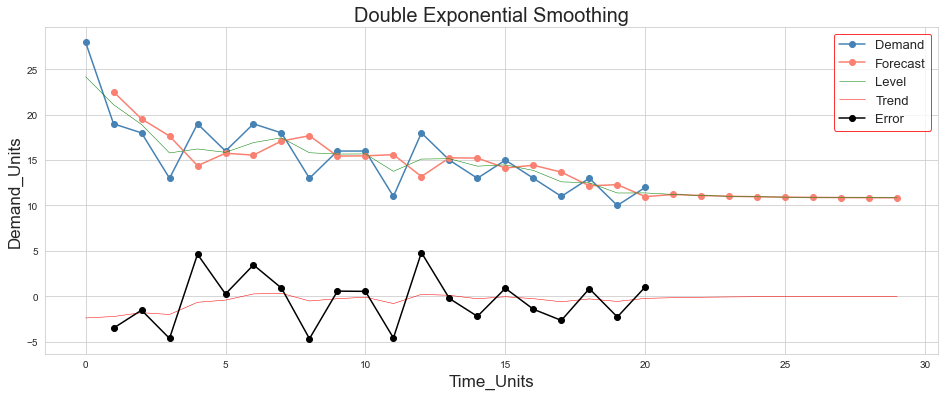

In [30]:
# Plot

fig, ax = plt.subplots(figsize = (16, 6))

ax.plot(df['Demand'], marker = 'o', color = 'steelblue', label = 'Demand')
ax.plot(df['Forecast'], marker = 'o', color = 'salmon', label = 'Forecast')
ax.plot(df['Level'], color = 'green', label = 'Level', linewidth = 0.5)
ax.plot(df['Trend'], color = 'red', label = 'Trend', linewidth = 0.5)
ax.plot(df['Error'], marker = 'o', color = 'black', label = 'Error')


ax.set_xlabel('Time_Units', fontsize = 17)
ax.set_ylabel('Demand_Units', fontsize = 17)

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)

ax.set_title('Double Exponential Smoothing', fontsize = 20)

plt.show()

Si vede che $\phi$ smorza il trend fino a renderlo quasi pari a 0. In ogni caso riduce l'impatto che questo ha sulla forecast e quindi impedisce una situazione di trend costante e infinito, che potrebbe portare a situazioni irrealistiche come ad esempio una domanda negativa (se proiettato molto nel futuro).

In ogni caso ancora una volta il **Double Exponential Smoothing con Damped Trend** non permette di riconoscere un pattern di domanda stagionale.

# 3) Triple Exponential Smoothing

L'idea qui è quella di aggiungere al modello un **multiplicative seasonal factor**, che permetta di includere la stagionalità. Infatti per ogni periodo modellato, verrà eseguita una moltiplicazione per il **seasonal factor** opportunamente pesato con **peso $\gamma$** in modo da amplificarne o smorzarne il valore.

Ad esempio considerando una serie storica con ciclo stagionale di 1 anno, ovvero che si ripete ogni anno "uguale" a sé stessa, determinare un **seasonal factor $s_{t}$** significa scoprire che ad esempio:
- A **gennaio** si vende il 20% il più della media di vendite annuali --> ogni gennaio della nostra serie storica sarà amplificato di questo 20% in più
- A **febbraio** di vende il 30% in meno della media di vendite annuali --> ogni febbraio della nostra serie storica saràsmorzato di un 30% in meno
- Ecc..

Nel nostro modello si considera una **stagionalità moltiplicativa**, ma vedremo anche il caso con la **stagionalità additiva**.

$ Forecast = (Level + Trend) Seasonality $

$ f_{t+1} = (a_{t} + \phi b_{t})s_{t+1-p}$

Quindi come si diceva, la forecast in t+1 è amplificata dalla stagionalità che ci deve essere in t+1. Supponendo che la serie abbia stagionalità pari a p, ovvero si ripete simile a sé stessa ogni p-periodi, utilizzo il fattore $s_{t+1-p}$.

**IMPORTANTE:** è necessario vedere questi fattori di stagionalità $s_{t}$ come delle **percentuali**, quindi tornando ai casi precedenti, fatta 100% la media di ventite annuali:
- A **gennaio** si vende il 20% il più della media di vendite annuali --> $s_{gennaio} = 120$ % 
- A **febbraio** di vende il 30% in meno della media di vendite annuali --> $s_{febbraio} = 70$ % 
- Ecc..

Le formule del modello sono queste:

$a_{t} = \alpha \frac{d_{t}}{s_{t-p}} + (1-\alpha)(a_{t-1} + \phi b_{t-1})$

$b_{t} = \beta (a_{t} - a_{t-1}) + (1-\beta) \phi b_{t-1}$

$s_{t} = \gamma \frac{d_{t}}{a_{t}} + (1-\gamma)a_{t-p}$

$f_{t+1} = (a_{t} + \phi b_{t})s_{t+1-p}$

## Considerazioni:

1) Si nota subito che sia $a_{t}$ che $b_{t}$ sono **destagionalizzati**:
- $a_{t}$ è calcolato come combinazione convessa della domanda $d_{t}$ destagionalizzata, ovvero divisa per la stagionalità $s_{t-p}$ e di $a_{t-1}$ che è anch'esso stato destagionalizzato al periodo $t-1$.
- $b_{t}$ è calcolato a partire da valori destagionalizzati e quindi sarà anch'esso destagionalizzato.

2) Il seasonal factor $s_{t}$ è calcolato considerando il parametro $\gamma$, che in teoria assume valori nell'intervallo [0.1], ma che all'atto pratico deve essere abbastanza piccolo, ovvero < 0.3. Questo perché con $\gamma$ elevati, si insegue la domanda d_{t} che si incontra periodo dopo periodo, modificando di volta in volta $s_{t}$, ma nella realtà è probabile che se un particolare business possiede una certa stagionatlità, allora questa sia abbastanza costante nel tempo. Quindi meglio dare più peso ai valori storici $s_{t-p}$ che a quelli innovativi $\frac{d_{t}}{s_{t-p}}$.

3) Il seassonal factor $s_{t}$ determina come la doamanda è allocata all'interno di un certo ciclo stagionale. Se ad esempio a gennario si vende il 20% in più, nel resto dell'anno si venderà il 20% in meno. Quindi vale la formula:

$\sum\limits_{cycle} s = p$

E quindi in media il valore per cui si moltiplia il livello $a_{t}$ è 1, facendo rimanere $a_{t}$ sulla stessa scala di $b_{t}$ e f_{t}:

$s_{medio} = \frac{1}{p}\sum\limits_{cycle} s = 1$



## Generalizzazione al periodo $t+\lambda$

Se poi vogliamo proiettare partendo da t ma per molteplici periodi $\lambda$:

1) Con **damping factor**

$f_{t+\lambda} = (a_{t} + b_{t}\sum\limits_{j=1}^{\lambda}\phi^{j})s_{t+\lambda-p}$

2) Senza **damping factor**

$f_{t+\lambda} = (a_{t} + \lambda b_{t})s_{t+\lambda-p}$

## Inizializzazione dei parametri

$a_{0} = \frac{d_{0}}{s_{0}}$

$b_{0} = \frac{d_{1}}{s_{1}} -  \frac{d_{0}}{s_{0}}$

Per quanto riguarda il **seasonal factor $s_{0}$** ci sono tanti modi di inizializzarlo, che vanno un attimo sperimentati.

## $s_{0}$ dalle medie stagionali

In pratica considerando la stagionalità della mia serie, che nella fattispecie è di 4 periodi, ovvero 1 anno, vado a vedere nel corso di 5 anni, quanto in media pesa ogni periodo in termine di vendite.

Per ottenere un valore %, scalo il **venduto di ogni perio, ovvero di ogni trimestre**, dividendolo per il venduto di un generico trimestre medio. Ottengo quindi che:
- nel primo trimestre vendo in media il 104% in più del trimestre medio, 
- nel secondo trimestre vendo in media il 15% in più del trimestre medio, 
- nel terzo trimestre vendo in media il -41% rispetto al trimestre medio,
- nel quarto trimestre vendo mediamente il -78% rispetto al trimestre medio.

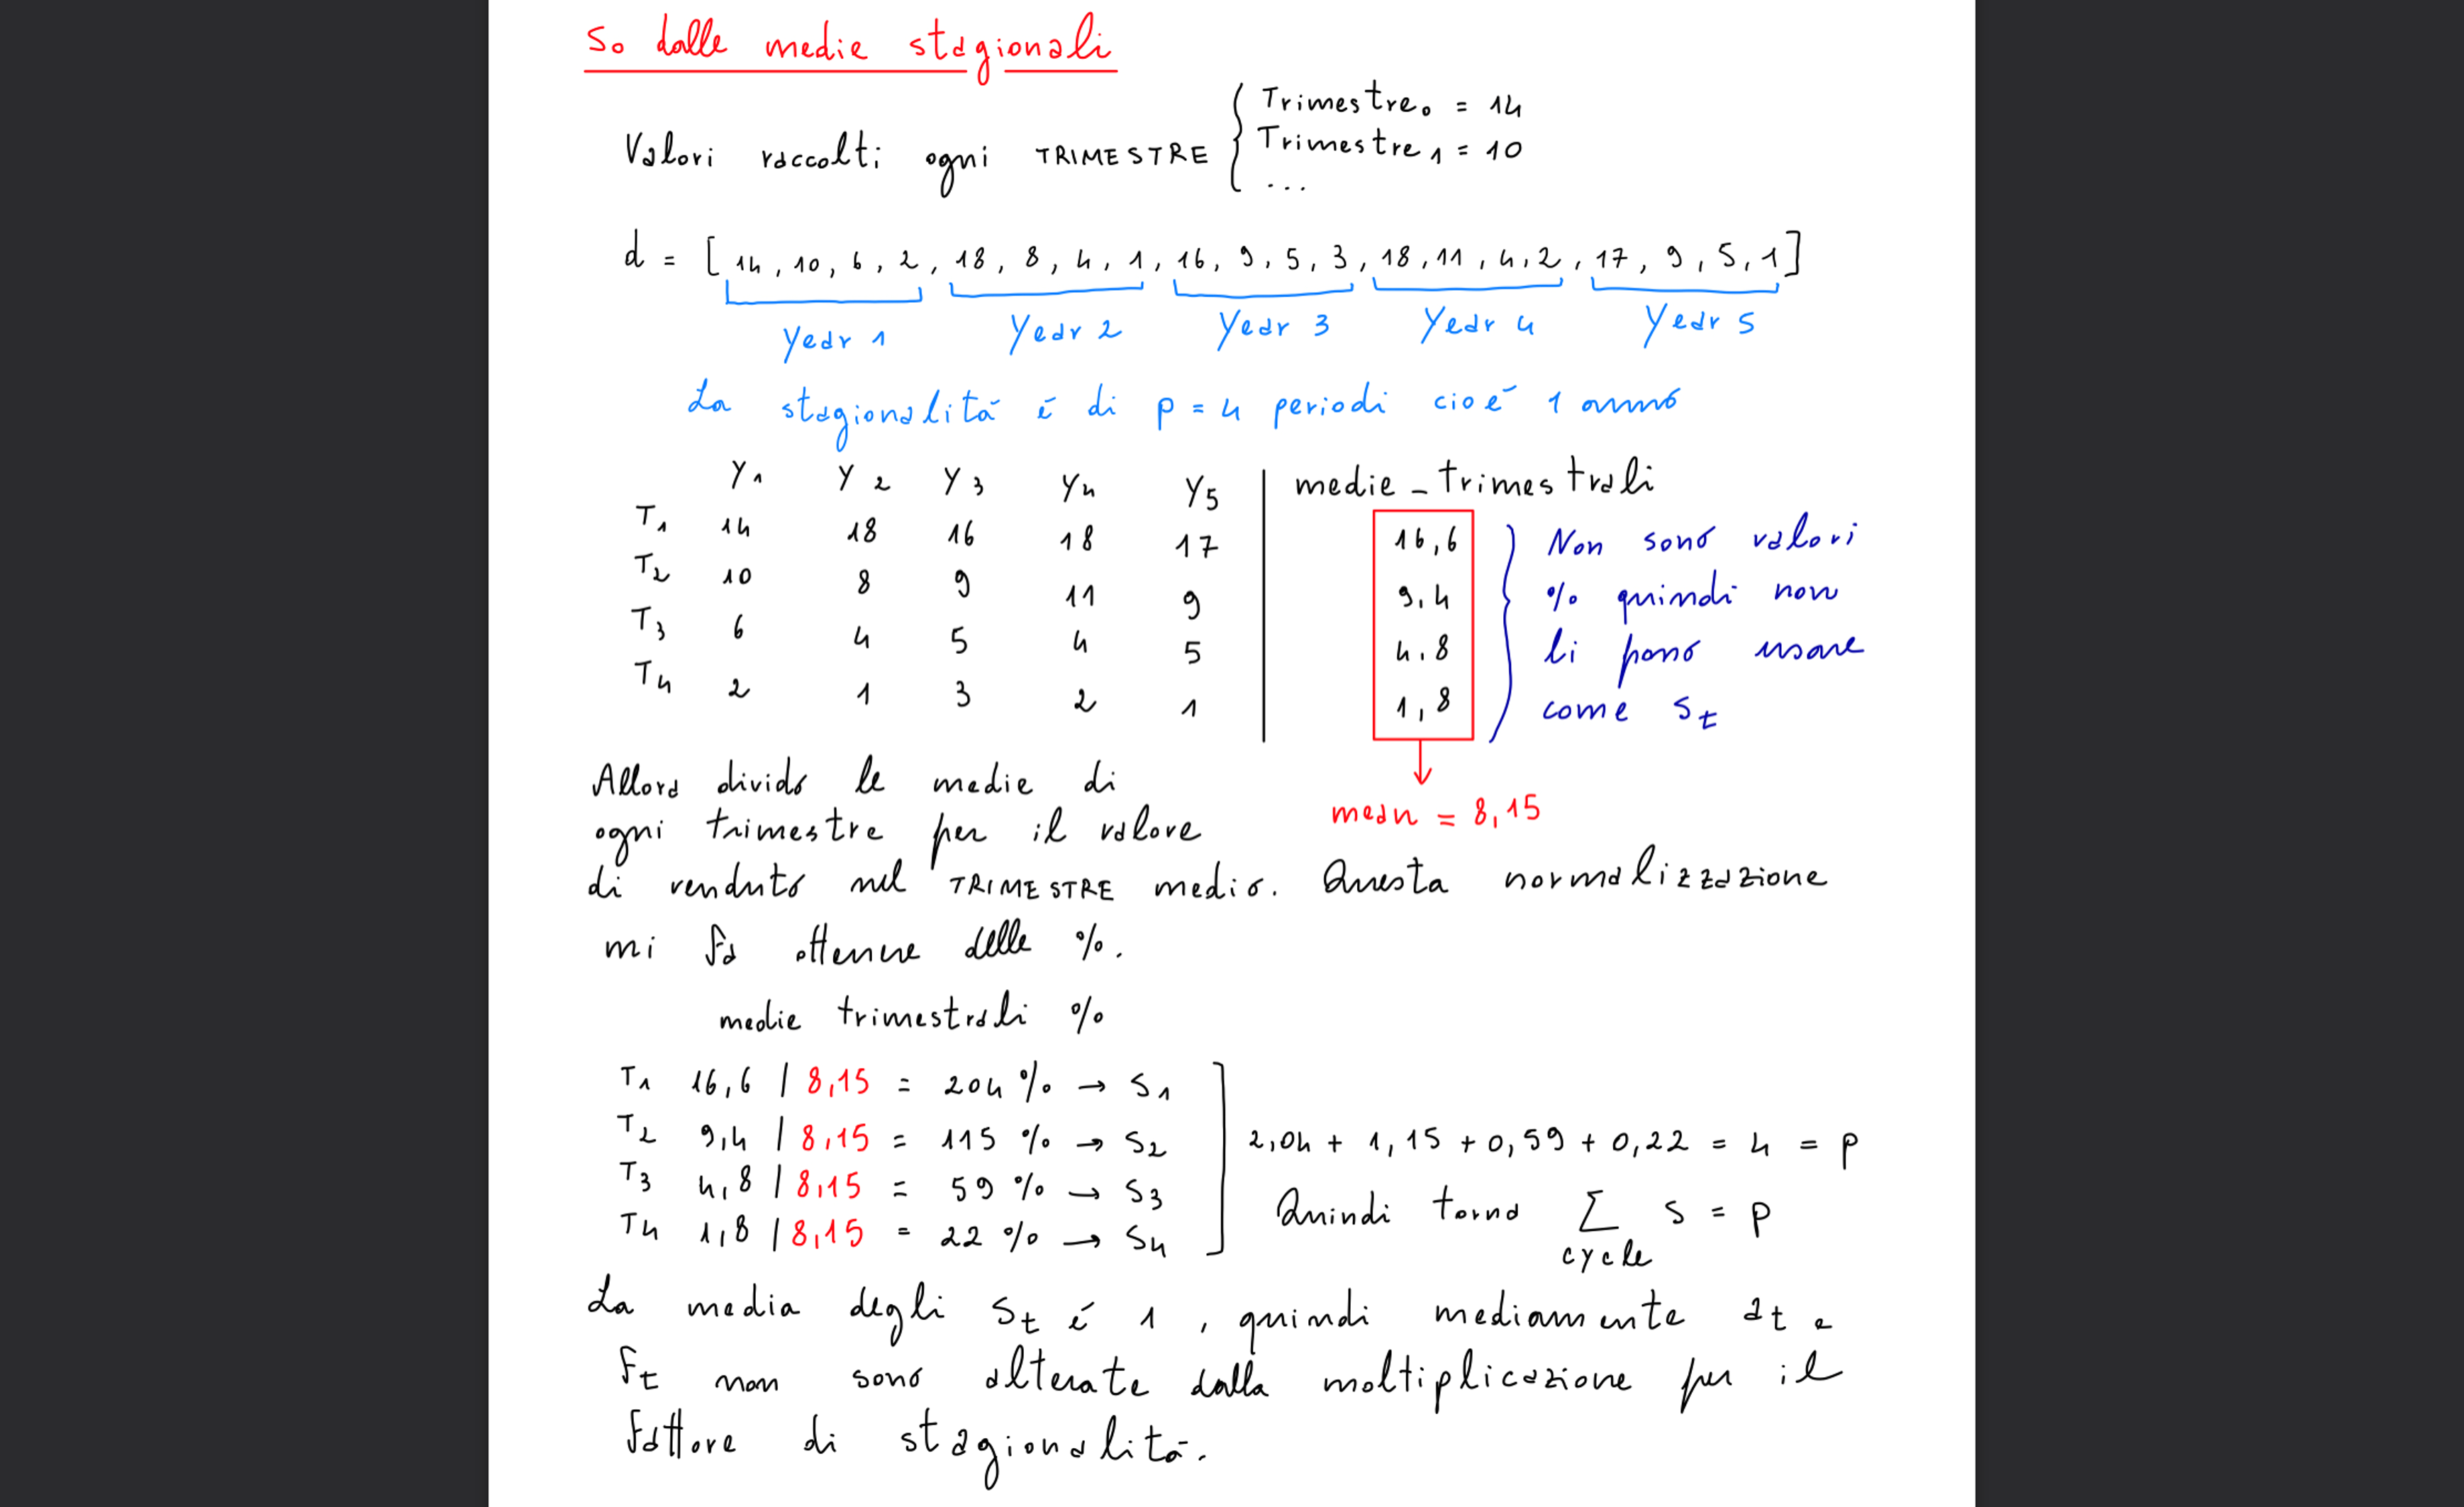

Al posto della **media**, si può anche usare la **mediana**, che dovrebbe aiutare ad eliminare outliers dai dati storici.

## Altri metodi

Ci sono tuttavia altri metodi per stimare i valori iniziali di $s_{0}$, come:
- Utilizzare solo la prima stagione storica
- Utilizzare coefficienti di stagionalità di prodotti simili
- Utilizzare il coefficiente che ritieni più adeguato in base alla conoscenza del business
- Ottimizzare i parametri in relazione a una funzione di costo, anche se rischi overfitting

In ogni caso è importante **scalare i coefficienti di stagionalità per la loro media**, in modo che la loro **somma sia uguale a p** e che quindi **possano essere interpretati come delle %**.

## Quando rimuovere il trend prima di cercare la stagionalità

Attenzione che se nelle domanda storica vedo un trend importante, talvolta è meglio **rimuovere il trend** prima di computare **$s_{0}$** con uno dei modi sopra visti. Altrimenti un **trend elevato** potrebbe essere scambiato per **stagionalità**.

## Modello

Prendo la domanda dell'esempio sopra, per cui sappiamo che la stagionalità è di 4 periodi.

Per prima cosa creo una funzione, che a partire dalla stagionalità, mi crea $s_{0}$, ovvero il coefficiente di stagionalità moltiplicativa.

Poi creo la funzione vera e propria Triple_Exp_Smooth.

In [31]:
d = [14, 10, 6, 2, 18, 8, 4, 1, 16, 9, 5, 3, 18, 11, 4, 2, 17, 9, 5, 1]

In [32]:
# s è un array che passo come argomento
# s_len è la lunghezza della stagione, ovvero p, quanti periodi servono per far iniziare e terminare la stagione

def seasonal_factor_mult(d, s, s_len, k):
    
    for j in range(0, s_len):
        s[j] = np.mean(d[j: k: s_len]) # media di j, j+s_len, j+2*s_len, ... fino al termine della domanda, ovvero k
        print(f'Calcolato s[{j}] pari a {s[j]}, ma non è ancora una %')
    
    # normalizzazione dividendo le medie di ogni trimestre, per il trimestre medio calcolato sui primi periodi
    s = s / np.mean(s[0:s_len]) # la somma dei primi s_len fattori di s deve essere proprio s_len
    for j in range(0, s_len):
        print(f'Calcolato s[{j}] = {round(s[j], 2)}, da interpretare come {round(s[j], 2)*100}%')
    
    return(s)

#Esempio

s_esempio = np.full(len(d), np.nan)
s_esempio = seasonal_factor_mult(d = d, s = s_esempio, s_len = 4, k = len(d))
s_esempio              

Calcolato s[0] pari a 16.6, ma non è ancora una %
Calcolato s[1] pari a 9.4, ma non è ancora una %
Calcolato s[2] pari a 4.8, ma non è ancora una %
Calcolato s[3] pari a 1.8, ma non è ancora una %
Calcolato s[0] = 2.04, da interpretare come 204.0%
Calcolato s[1] = 1.15, da interpretare come 114.99999999999999%
Calcolato s[2] = 0.59, da interpretare come 59.0%
Calcolato s[3] = 0.22, da interpretare come 22.0%


array([2.03680982, 1.15337423, 0.58895706, 0.2208589 ,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

In [33]:
def Triple_Exp_Smooth_Damped(d, s_len = 12, extra_periods = 5,  alpha = 0.4, beta = 0.4, phi = 0.9, gamma = 0.3):
    
    k = len(d)
    
    #Creo gli array
    d = np.append(d, [np.nan]*extra_periods) #Demand
    f = np.full(k + extra_periods, np.nan) #Forecast
    a = np.full(k + extra_periods, np.nan) #Level
    b = np.full(k + extra_periods, np.nan) #Trend
    s = np.full(k + extra_periods, np.nan) #Seasonal factor
    
    # Inizializzo la stagionalità col metodo sopra visto
    s = seasonal_factor_mult(d = d, s = s, s_len = s_len, k = k)
    
    #Inizializzo livello e trend
    a[0] = d[0]/s[0]
    b[0] = d[1]/s[1] - d[0]/s[0] # data leakage
    print('Coefficienti computati con inizializzazione semplice:')
    print(f'a[0] = d[0]/s[0] = {a[0]} \nb[0] = d[1]/s[1]  - d[0]/s[0] = {b[0]}')
    
    
    #Creo la forecast per la prima stagione per cui ho calcolato i coefficienti s
    for t in range(1, s_len):
        f[t] = (a[t-1] + phi*b[t-1])*s[t] # 1) Computo la forecast
        a[t] = alpha * d[t]/s[t] + (1-alpha)*(a[t-1] + phi*b[t-1]) # 2) Aggiusto il livello a[t] in base alla f[t] e d[t]
        b[t] = beta * (a[t] - a[t-1]) + (1-beta)*phi*b[t-1] # 3) Aggiusto il trend sulla base di a[t] appena aggiornato
    
    
    #Qui considero i coefficienti di stagionalità computati per la prima stagione
    for t in range(s_len, k):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-s_len] # 1) Computo la forecast 
        a[t] = alpha * d[t]/s[t-s_len] + (1-alpha)*(a[t-1] + phi*b[t-1]) # 2) Aggiusto il livello a[t]
        b[t] = beta * (a[t] - a[t-1]) + (1-beta)*phi*b[t-1] # 3) Aggiusto il trend
        s[t] = gamma * (d[t] / a[t]) + (1-gamma)*s[t-s_len] # 4) Aggiusto la stagionalità
    
    
    for t in range(k, k + extra_periods):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-s_len] # 1) Computo la forecast
        a[t] = f[t]/s[t-s_len] # 2) Il livello equivale alla forecast e cresce di ogni periodo di un valore pari al trend b[t]
        b[t] = phi*b[t-1] # 3) Il trend è smorzato esponenzialmente
        s[t] = s[t-s_len] # 4) La stagionalità è quella dell'ultima stagione computata
        
    #Creo df
    df = pd.DataFrame({'Demand': d,
                       'Forecast':f,
                       'Level': a,
                       'Trend': b,
                       'Season': s, 
                       'Error': d-f})
    
    return(df)

In [34]:
df = Triple_Exp_Smooth_Damped(d, s_len = 4, extra_periods = 4, alpha = 0.3, beta = 0.2, phi = 0.9, gamma = 0.2)
df

Calcolato s[0] pari a 16.6, ma non è ancora una %
Calcolato s[1] pari a 9.4, ma non è ancora una %
Calcolato s[2] pari a 4.8, ma non è ancora una %
Calcolato s[3] pari a 1.8, ma non è ancora una %
Calcolato s[0] = 2.04, da interpretare come 204.0%
Calcolato s[1] = 1.15, da interpretare come 114.99999999999999%
Calcolato s[2] = 0.59, da interpretare come 59.0%
Calcolato s[3] = 0.22, da interpretare come 22.0%
Coefficienti computati con inizializzazione semplice:
a[0] = d[0]/s[0] = 6.873493975903614 
b[0] = d[1]/s[1]  - d[0]/s[0] = 1.7967187900538324


Demand   Forecast      Level     Trend    Season     Error
0     14.0        NaN   6.873494  1.796719  2.036810       NaN
1     10.0   9.792771   8.544442  1.627827  1.153374  0.207229
2      6.0   5.895158  10.062891  1.475725  0.588957  0.104842
3      2.0   2.515813  10.690397  1.188023  0.220859 -0.515813
4     18.0  23.952106  10.882938  0.893885  1.960241 -5.952106
5      8.0  13.479985  10.262055  0.519421  1.078614 -5.479985
6      4.0   6.319234   9.548173  0.231207  0.554951 -2.319234
7      1.0   2.154757   8.187715 -0.105623  0.201114 -1.154757
8     16.0  15.863552   8.113537 -0.090884  1.962595  0.136448
9      9.0   8.663145   8.125432 -0.063058  1.084418  0.336855
10     5.0   4.477725   8.351016 -0.000285  0.563707  0.522275
11     3.0   1.679454  10.320607  0.393713  0.219027  1.320546
12    18.0  20.950604  10.223923  0.264137  1.922192 -2.950604
13    11.0  11.344792  10.366260  0.218646  1.079761 -0.344792
14     4.0   5.954460   9.522895 -0.011248  0.534974 -1.954460
15     2.0   2.083557   9.398325 -0.033013  0.217783 -0.083557
16    17.0  18.008270   9.211251 -0.061184  1.906867 -1.008270
17     9.0   9.886492   8.909883 -0.104326  1.065832 -0.886492
18     5.0   4.716322   8.975069 -0.062077  0.539399  0.283678
19     1.0   1.942447   7.620960 -0.315518  0.200469 -0.942447
20     NaN  13.990674   7.336995 -0.283966  1.906867       NaN
21     NaN   7.547607   7.081425 -0.255569  1.065832       NaN
22     NaN   3.695643   6.851413 -0.230012  0.539399       NaN
23     NaN   1.332000   6.644402 -0.207011  0.200469       NaN

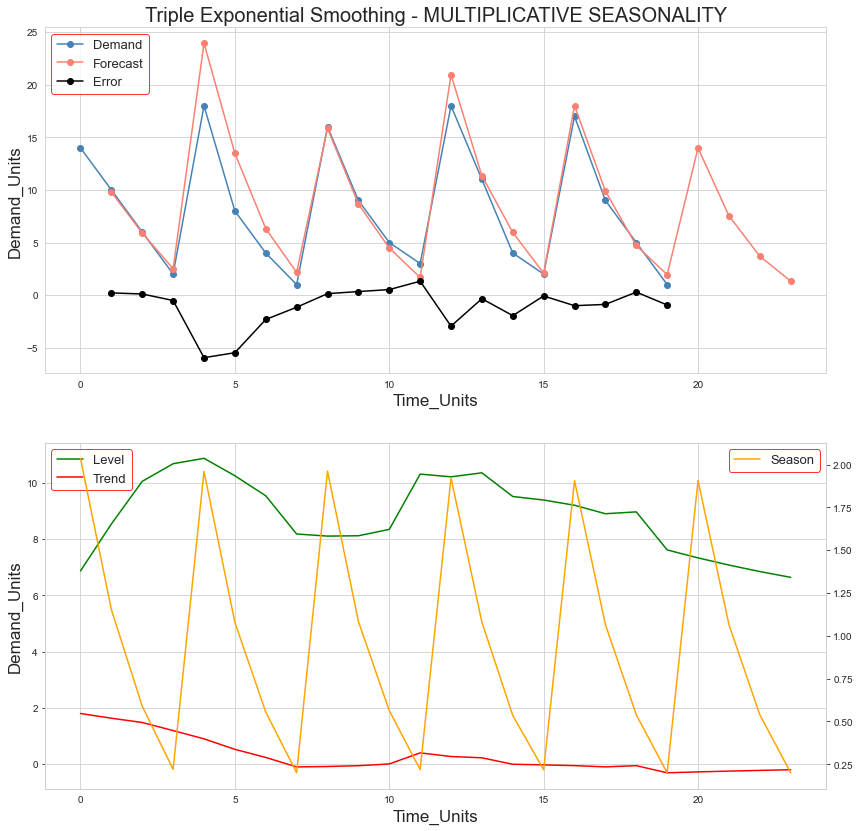

In [35]:
# Plot

fig, ax = plt.subplots(2, figsize = (14, 14))

ax[0].plot(df['Demand'], marker = 'o', color = 'steelblue', label = 'Demand')
ax[0].plot(df['Forecast'], marker = 'o', color = 'salmon', label = 'Forecast')
ax[0].plot(df['Error'], marker = 'o', color = 'black', label = 'Error')

ax[1].plot(df['Level'], color = 'green', label = 'Level')
ax[1].plot(df['Trend'], color = 'red', label = 'Trend')
ax2 = ax[1].twinx()
ax2.grid(False)
ax2.plot(df['Season'], color = 'orange', label = 'Season')


ax[0].set_xlabel('Time_Units', fontsize = 17)
ax[1].set_xlabel('Time_Units', fontsize = 17)
ax[0].set_ylabel('Demand_Units', fontsize = 17)
ax[1].set_ylabel('Demand_Units', fontsize = 17)

ax[0].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')
ax[1].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')
ax2.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper right')

ax[0].set_title('Triple Exponential Smoothing - MULTIPLICATIVE SEASONALITY', fontsize = 20)

plt.show()

# Air Passengers

Questa serie ha sia trend che stagionalità, quindi il Triple_Exponential_Smoothing dovrebbe andare bene. Tuttavia dato che presenta un elevato trend, è opportuno detrendizzare la serie prima di calcolare i coefficienti di stagionalità $s_{j}$.

Per detrendizzare la serie è possibile fare in 2 modi:
1) **DETREND con attività di DIFFERENCING**

2) **DETREND con MODEL FITTING**

Importiamo la serie e dopo facciamo entrambe

In [36]:
d = pd.read_csv(r'C:\Users\peria\Desktop\DATA SCIENCE\TIME SERIES\Data Science For Supply Chain Forecasting\AirPassengers.csv')
d['Month'] = pd.to_datetime(d['Month'], yearfirst = True)
d.set_index(d['Month'], inplace = True)
d.drop(columns = ['Month'], inplace = True)
d.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

### 1) DETREND con attività di DIFFERENCING

Attenzione che se la serie ha un trend lineare, allora questo può essere rimosso facendo le differenze del primo ordine, ovvero andando a sottrarre dall'osservazione $X[t]$ l'osservazione in $X[t-1]$. Quindi $X[t] = X[t] - X[t-1]$.

Se invece la serie mostra un trend quadratico, allora potrebbe essere necessario eseguire le differenze del secondo ordine, ovvero fare due volte le differenze.

Questa attività si può compiere molte volte a seconda di quanto serve.


In [37]:
d['Passengers_Detrend_Diff'] = d['Passengers'] - d['Passengers'].shift(1)

d.head()

Passengers  Passengers_Detrend_Diff
Month                                          
1949-01-01         112                      NaN
1949-02-01         118                      6.0
1949-03-01         132                     14.0
1949-04-01         129                     -3.0
1949-05-01         121                     -8.0

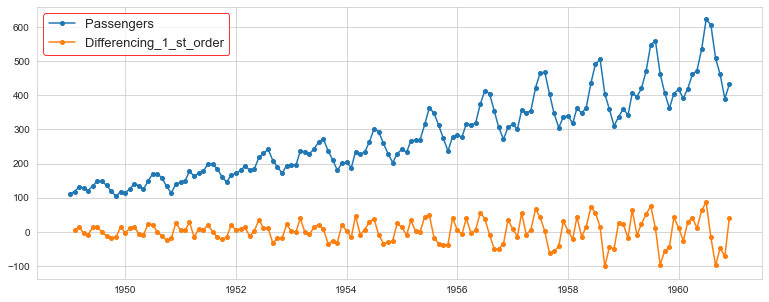

In [38]:
fig, ax = plt.subplots(figsize = (13, 5))

ax.plot(d['Passengers'], marker = '.', markersize = 8, label = 'Passengers')
ax.plot(d['Passengers_Detrend_Diff'], marker = '.', markersize = 8, label = 'Differencing_1_st_order')

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')

plt.show()

### 2) DETREND con attività di MODEL FITTING

Ad esempio nel caso di trend lineare, si può fittare una regressione lineare sulla serie e sottrarre la retta di regressione, che appunto rappresenta il trend della serie.

In [39]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept = True, normalize = True)

X = np.arange(0, len(d), 1).reshape(-1, 1)
y = d['Passengers'].values.reshape(-1, 1)

linear_model.fit(X, y)

coefficiente = linear_model.coef_[0][0]
intercetta = linear_model.intercept_[0]

pred = linear_model.predict(X)

print(f'Intercetta: {intercetta}', f'\nCoefficiente Angolare: {coefficiente}')

Intercetta: 90.30996168582371 
Coefficiente Angolare: 2.6571839080459774


In [40]:
d['Trend_Fit_Model'] = pred

d['Passengers_Detrend_Fit_Model'] = d['Passengers'] - d['Trend_Fit_Model']

d.head()

Passengers  Passengers_Detrend_Diff  Trend_Fit_Model  \
Month                                                              
1949-01-01         112                      NaN        90.309962   
1949-02-01         118                      6.0        92.967146   
1949-03-01         132                     14.0        95.624330   
1949-04-01         129                     -3.0        98.281513   
1949-05-01         121                     -8.0       100.938697   

            Passengers_Detrend_Fit_Model  
Month                                     
1949-01-01                     21.690038  
1949-02-01                     25.032854  
1949-03-01                     36.375670  
1949-04-01                     30.718487  
1949-05-01                     20.061303

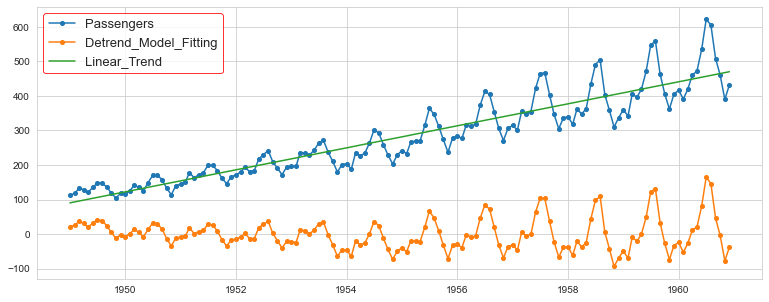

In [41]:
fig, ax = plt.subplots(figsize = (13, 5))

ax.plot(d['Passengers'], marker = '.', markersize = 8, label = 'Passengers')
ax.plot(d['Passengers_Detrend_Fit_Model'], marker = '.', markersize = 8, label = 'Detrend_Model_Fitting')
ax.plot(d['Trend_Fit_Model'], label = 'Linear_Trend')

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')

plt.show()

### ...Tornando ad Air Passengers...

In [42]:
# La stagionalità è annuale, quindi s_len = 12

df = Triple_Exp_Smooth_Damped(d['Passengers'], s_len = 12, extra_periods = 36, alpha = 0.3, beta = 0.2, phi = 0.98, gamma = 0.2)
df.head()

Calcolato s[0] pari a 241.75, ma non è ancora una %
Calcolato s[1] pari a 235.0, ma non è ancora una %
Calcolato s[2] pari a 270.1666666666667, ma non è ancora una %
Calcolato s[3] pari a 267.0833333333333, ma non è ancora una %
Calcolato s[4] pari a 271.8333333333333, ma non è ancora una %
Calcolato s[5] pari a 311.6666666666667, ma non è ancora una %
Calcolato s[6] pari a 351.3333333333333, ma non è ancora una %
Calcolato s[7] pari a 351.0833333333333, ma non è ancora una %
Calcolato s[8] pari a 302.4166666666667, ma non è ancora una %
Calcolato s[9] pari a 266.5833333333333, ma non è ancora una %
Calcolato s[10] pari a 232.83333333333334, ma non è ancora una %
Calcolato s[11] pari a 261.8333333333333, ma non è ancora una %
Calcolato s[0] = 0.86, da interpretare come 86.0%
Calcolato s[1] = 0.84, da interpretare come 84.0%
Calcolato s[2] = 0.96, da interpretare come 96.0%
Calcolato s[3] = 0.95, da interpretare come 95.0%
Calcolato s[4] = 0.97, da interpretare come 97.0%
Calcolato s[5]

Demand    Forecast       Level      Trend    Season      Error
0   112.0         NaN  129.859129  10.886557  0.862473        NaN
1   118.0  117.817456  140.593274  10.681889  0.838392   0.182544
2   132.0  145.601109  146.828169   9.621580  0.963853 -13.601109
3   129.0  148.890233  149.994998   8.176685  0.952853 -19.890233
4   121.0  153.236156  148.036138   6.018749  0.969799 -32.236156

In [43]:
df.tail(36)

Demand    Forecast       Level     Trend    Season  Error
144     NaN  455.586464  494.995302  2.549736  0.920385    NaN
145     NaN  437.757327  497.494043  2.498741  0.879925    NaN
146     NaN  502.355145  499.942809  2.448766  1.004825    NaN
147     NaN  497.721945  502.342600  2.399791  0.990802    NaN
148     NaN  504.600668  504.694395  2.351795  0.999814    NaN
149     NaN  573.037487  506.999154  2.304759  1.130253    NaN
150     NaN  640.660356  509.257818  2.258664  1.258028    NaN
151     NaN  632.872250  511.471308  2.213491  1.237356    NaN
152     NaN  538.591183  513.640529  2.169221  1.048576    NaN
153     NaN  475.818833  515.766365  2.125836  0.922547    NaN
154     NaN  415.996191  517.849685  2.083320  0.803315    NaN
155     NaN  469.235841  519.891338  2.041653  0.902565    NaN
156     NaN  480.341939  521.892158  2.000820  0.920385    NaN
157     NaN  460.951193  523.852962  1.960804  0.879925    NaN
158     NaN  528.311531  525.774550  1.921588  1.004825    NaN
159     NaN  522.804197  527.657706  1.883156  0.990802    NaN
160     NaN  529.404865  529.503199  1.845493  0.999814    NaN
161     NaN  600.516916  531.311782  1.808583  1.130253    NaN
162     NaN  670.634593  533.084193  1.772411  1.258028    NaN
163     NaN  661.764331  534.821156  1.736963  1.237356    NaN
164     NaN  562.585593  536.523380  1.702224  1.048576    NaN
165     NaN  496.507134  538.191559  1.668179  0.922547    NaN
166     NaN  433.650387  539.826375  1.634816  0.803315    NaN
167     NaN  488.674530  541.428495  1.602119  0.902565    NaN
168     NaN  499.767974  542.998572  1.570077  0.920385    NaN
169     NaN  479.151807  544.537247  1.538676  0.879925    NaN
170     NaN  548.679940  546.045149  1.507902  1.004825    NaN
171     NaN  542.486660  547.522893  1.477744  0.990802    NaN
172     NaN  548.869134  548.971082  1.448189  0.999814    NaN
173     NaN  622.080483  550.390308  1.419225  1.130253    NaN
174     NaN  694.155878  551.781149  1.390841  1.258028    NaN
175     NaN  684.436431  553.144173  1.363024  1.237356    NaN
176     NaN  581.414409  554.479936  1.335764  1.048576    NaN
177     NaN  512.741589  555.788984  1.309048  0.922547    NaN
178     NaN  447.503929  557.071852  1.282867  0.803315    NaN
179     NaN  503.928393  558.329062  1.257210  0.902565    NaN

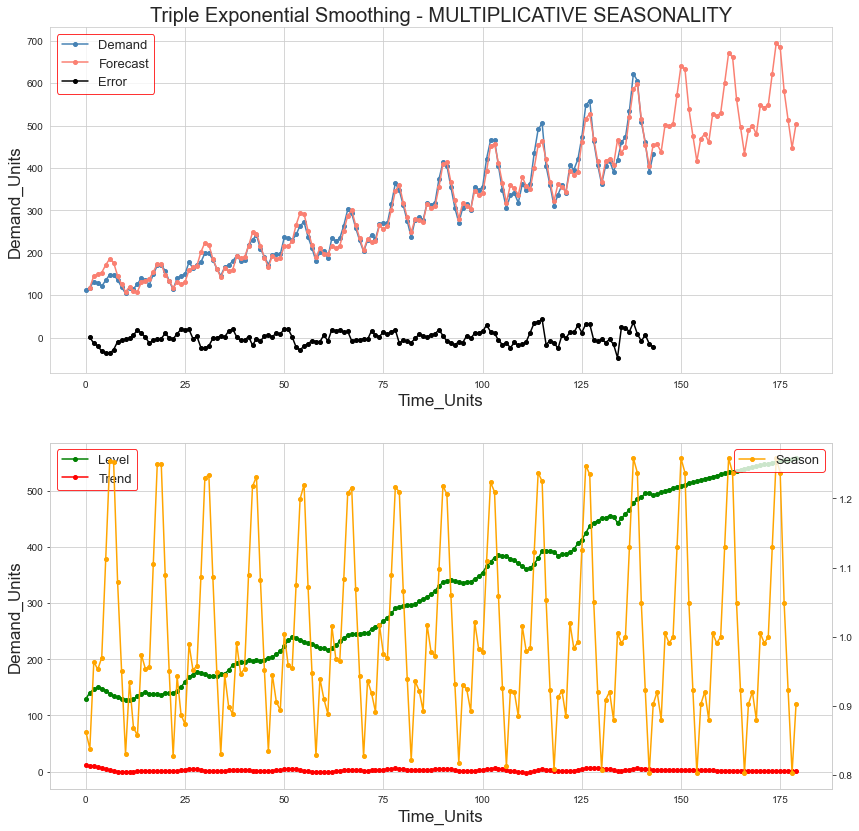

In [44]:
# Plot

fig, ax = plt.subplots(2, figsize = (14, 14))

ax[0].plot(df['Demand'], color = 'steelblue', label = 'Demand', marker = '.', markersize = 8)
ax[0].plot(df['Forecast'], color = 'salmon', label = 'Forecast', marker = '.', markersize = 8)
ax[0].plot(df['Error'], color = 'black', label = 'Error', marker = '.', markersize = 8)

ax[1].plot(df['Level'], color = 'green', label = 'Level', marker = '.', markersize = 8)
ax[1].plot(df['Trend'], color = 'red', label = 'Trend', marker = '.', markersize = 8)
ax2 = ax[1].twinx()
ax2.grid(False)
ax2.plot(df['Season'], color = 'orange', label = 'Season', marker = '.', markersize = 8)


ax[0].set_xlabel('Time_Units', fontsize = 17)
ax[1].set_xlabel('Time_Units', fontsize = 17)
ax[0].set_ylabel('Demand_Units', fontsize = 17)
ax[1].set_ylabel('Demand_Units', fontsize = 17)

ax[0].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')
ax[1].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')
ax2.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper right')

ax[0].set_title('Triple Exponential Smoothing - MULTIPLICATIVE SEASONALITY', fontsize = 20)

plt.show()

# Outliers

Trovare gli outliers è un task fondamentale per ottenere migliori forecast. Pulendo il dataset dagli outliers, è possibile ottenere valori di accuratezza delle forecast migliori di anche 2 punti %.

Adesso vediamo 3 idee chiave che si possono usare per trovare degli outliers:
1) **WINSORIZATION**

2) **STANDARD DEVIATION**

3) **ERROR STANDARD DEVIATION**

# 1) WINSORIZATION

Un outlier è un valore eccezionalmente alto o eccezionalmente basso, quindi l'idea della **WINSORIZATION** è semplicemente quella di tagliare i K-valori più alti e bassi del dataset.

Per farlo si utilizza la **tecnica del percentile**. 

Il **percentile x-esimo** è il valore **SOTTO** il quale stanno il **x%** delle osservazioni.
Ad esempio il 99% delle osservazioni che compongono la domanda di un codice, stanno sotto il suo 99-esimo percentile.

In [45]:
array_dummy_1 = np.array([17, 12, 7, 5, 4, 9, 13, 14, 11, 11, 10, 12, 6, 11, 14, 15, 8, 12,
                          14, 14, 11, 10, 7, 15, 9, 8, 5, 12, 10, 8, 9 , 10, 8, 16, 8, 10])

array_dummy_2 =  np.array([17, 12, 7, 5, 4, 9, 13, 14, 11, 11, 10, 12, 6, 11, 14, 15, 8, 12,
                           100, 14, 11, 10, 7, 15, 9, 8, 5, 12, 10, 8, 9 , 10, 8, 16, 8, 10])



In [46]:
year = np.full(len(array_dummy_1), np.nan)
month = np.full(len(array_dummy_1), np.nan)

In [47]:
start = 0
value = 1
while start < len(year):
    year[start:start+12] = value
    value += 1
    start += 12

#--------------------------------

for j in range(0, 12):
    month[j: len(month): 12] = j + 1

print('\n', year, '\n', month)


 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.] 
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.  1.  2.  3.  4.  5.  6.
  7.  8.  9. 10. 11. 12.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


In [48]:
df_dummy_1 = pd.DataFrame({'d': array_dummy_1,
                           'Year': year, 
                           'Month': month})

df_dummy_2 = pd.DataFrame({'d': array_dummy_2,
                           'Year': year,
                           'Month': month})

In [49]:
df_dummy_1.head()

d  Year  Month
0  17   1.0    1.0
1  12   1.0    2.0
2   7   1.0    3.0
3   5   1.0    4.0
4   4   1.0    5.0

In [50]:
table_dummy_1 = pd.pivot_table(df_dummy_1, index = 'Year', columns = 'Month')
table_dummy_1

d                                                       
Month 1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0 11.0 12.0
Year                                                             
1.0     17   12    7    5    4    9   13   14   11   11   10   12
2.0      6   11   14   15    8   12   14   14   11   10    7   15
3.0      9    8    5   12   10    8    9   10    8   16    8   10

In [51]:
table_dummy_2 = pd.pivot_table(df_dummy_2, index = 'Year', columns = 'Month')
table_dummy_2

d                                                       
Month 1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0 11.0 12.0
Year                                                             
1.0     17   12    7    5    4    9   13   14   11   11   10   12
2.0      6   11   14   15    8   12  100   14   11   10    7   15
3.0      9    8    5   12   10    8    9   10    8   16    8   10

In [52]:
lower_limit_1, upper_limit_1 = ( np.percentile(df_dummy_1['d'].values, 1), np.percentile(df_dummy_1['d'].values, 99) )
lower_limit_2, upper_limit_2 = ( np.percentile(df_dummy_2['d'].values, 1), np.percentile(df_dummy_2['d'].values, 99) )

print((lower_limit_1, upper_limit_1))
print((lower_limit_2, upper_limit_2))

(4.35, 16.65)
(4.35, 70.94999999999987)


Quindi in entrambi i dataset, l'1% dei valori più bassi saranno incrementati a 4.35.

Perché **NON ci piace** la Winsorizzazione:
- Il l'1% dei valori più alti nel primo dataset saranno messi a 16.65, mentre nel seconndo a 70.95. Questi sono valori molto diversi. In particolare nel secondo dataset anche il valore 70.95 è un outlier e quindi benché abbiamo ridotto il suo valore, non abbiamo risolto la situazione. Resta infatti un outlier.

- Al contrario nel primo dataset, benché non ci fossero outliers, sono stati individuati comunque 2 valori che verranno eliminati e rimpiazzari con il 1° e il 99° percentile del campione originario.

- Inoltre la Winsorizzazione, restituisce dei valori reali, quando in nei dataset di partenza i nostri valori erano tutti interi.



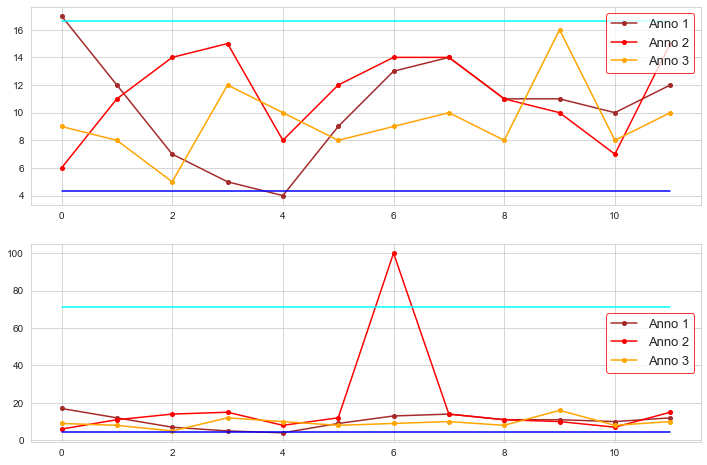

In [53]:
fig, ax = plt.subplots(2, figsize = (12,8))

dict_color = {0: 'brown',
              1: 'red', 
              2: 'orange'}

for j in range(len(table_dummy_1)):
    ax[0].plot(table_dummy_1.iloc[j, :].values, label = 'Anno {}'.format(j+1), 
               color = dict_color[j], marker = '.', markersize = 8 )
    
for j in range(len(table_dummy_2)):
    ax[1].plot(table_dummy_2.iloc[j, :].values, label = 'Anno {}'.format(j+1), 
               color = dict_color[j], marker = '.', markersize = 8)
    
ax[0].plot(np.ones(12)*lower_limit_1, color = 'blue')
ax[0].plot(np.ones(12)*upper_limit_1, color = 'cyan')

ax[1].plot(np.ones(12)*lower_limit_2, color = 'blue')
ax[1].plot(np.ones(12)*upper_limit_2, color = 'cyan')

ax[0].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)
ax[1].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)
plt.show()

In [54]:
#array_dummy_1 = np.clip(array_dummy_1, a_min = lower_limit_1, a_max = upper_limit_1)
#array_dummy_2 = np.clip(array_dummy_2, a_min = lower_limit_2, a_max = upper_limit_2)

#array_dummy_1, array_dummy_2

# 2) STANDARD DEVIATION

Abbiamo visto che la WINSORIZATION non è il miglior modo per filtrare outliers, perché elimina i valori più alti e più bassi anche se questi non sono da considerare outliers in senso assoluto.

Quindi un ulteriore criterio è quello della DEVIAZIONE STANDARD attorno alla MEDIA, che permette di filtrare i valori che si discostano troppo da tale valore.

Questo è il classico criterio $[\mu - X\sigma, \mu + X\sigma]$, dove $X$ è un valore arbitrario, pari a 2, 3 ecc..

Più la domanda di un codice è coatica e più queste queste soglie saranno larghe.

Ad esempio data una domanda con una certa $\sigma$ e una certa $\mu$, al 98% le mie osservazioni saranno comprese nell'intervallo $[\mu - \sigma q_{1-\frac{0.98}{2}}, \mu + \sigma q_{1-\frac{0.98}{2}}]$.

Perché considerando $Z$ la gaussiana standard:

$ \alpha = P(- q_{1-\frac{\alpha}{2}} < Z < q_{1-\frac{\alpha}{2}}) = P(Z < q_{1-\frac{\alpha}{2}}) - P(Z < - q_{\frac{\alpha}{2}}) = (1-\frac{\alpha}{2}) - \frac{\alpha}{2}$

Ricorda che la gaussiana standard $Z$ si ottiene da una gaussiana non standard $X$ semplicemente standardizzando, ovvero sottraendo la media $\mu$ di $X$ e dividendo per la deviazione standard $\sigma$ di $X$:

$Z = \frac{X-\mu}{\sigma}$

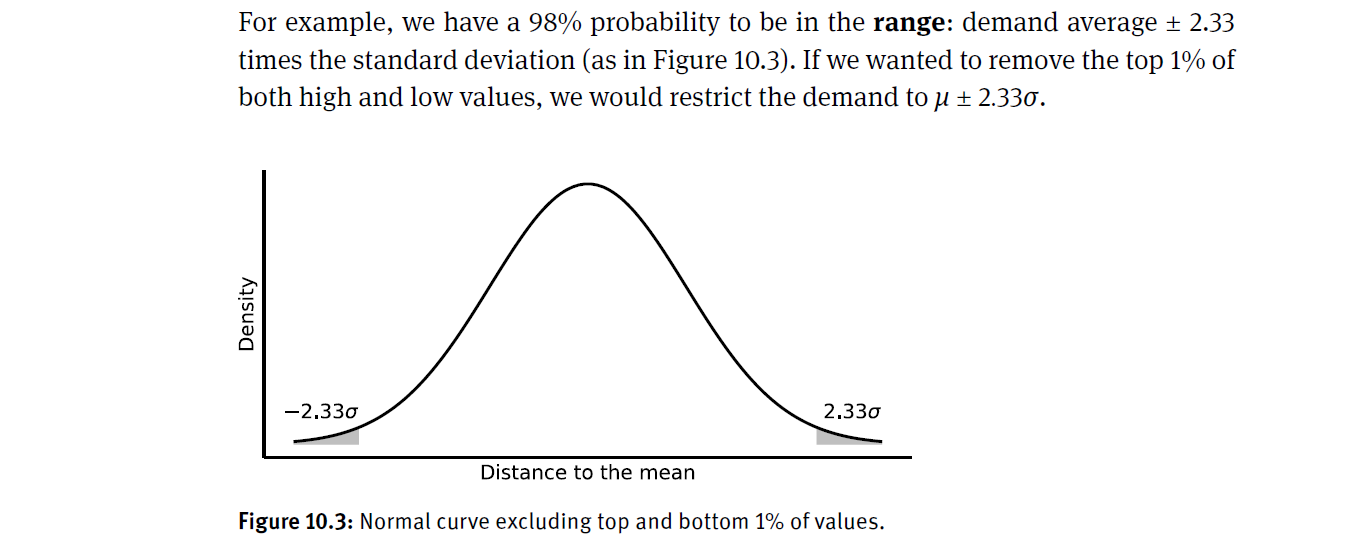

In [55]:
mean_1 = array_dummy_1.mean()
mean_2 = array_dummy_2.mean()

sd_1 = array_dummy_1.std()
sd_2 = array_dummy_2.std()

In [56]:
alpha = 0.99
q = norm.ppf(alpha)
q

lower_limit_1, upper_limit_1 = mean_1 - q*sd_1, mean_1 + q*sd_1
lower_limit_2, upper_limit_2 = mean_2 - q*sd_2, mean_2 + q*sd_2

print((lower_limit_1, upper_limit_1))
print((lower_limit_2, upper_limit_2))

(3.011734950935532, 17.821598382397802)
(-22.243634875483586, 47.8547459865947)


In [57]:
#Alternativamente

lower_limit_1, upper_limit_1 = norm.ppf(0.01, mean_1, sd_1), norm.ppf(0.99, mean_1, sd_1)
lower_limit_2, upper_limit_2 = norm.ppf(0.01, mean_2, sd_2), norm.ppf(0.99, mean_2, sd_2)

print((lower_limit_1, upper_limit_1))
print((lower_limit_2, upper_limit_2))

(3.011734950935532, 17.821598382397802)
(-22.243634875483586, 47.8547459865947)


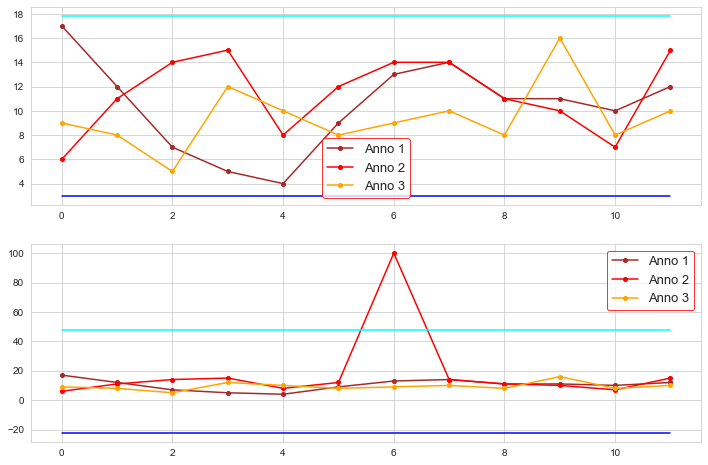

In [58]:
fig, ax = plt.subplots(2, figsize = (12,8))

dict_color = {0: 'brown',
              1: 'red', 
              2: 'orange'}

for j in range(len(table_dummy_1)):
    ax[0].plot(table_dummy_1.iloc[j, :].values, label = 'Anno {}'.format(j+1), 
               color = dict_color[j], marker = '.', markersize = 8 )
    
for j in range(len(table_dummy_2)):
    ax[1].plot(table_dummy_2.iloc[j, :].values, label = 'Anno {}'.format(j+1), 
               color = dict_color[j], marker = '.', markersize = 8)
    
ax[0].plot(np.ones(12)*lower_limit_1, color = 'blue')
ax[0].plot(np.ones(12)*upper_limit_1, color = 'cyan')

ax[1].plot(np.ones(12)*lower_limit_2, color = 'blue')
ax[1].plot(np.ones(12)*upper_limit_2, color = 'cyan')

ax[0].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)
ax[1].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13)
plt.show()

In [59]:
#array_dummy_1 = np.clip(array_dummy_1, a_min = lower_limit_1, a_max = upper_limit_1)
#array_dummy_2 = np.clip(array_dummy_2, a_min = lower_limit_2, a_max = upper_limit_2)

#array_dummy_1, array_dummy_2

Il risultato ci piace molto più di prima perché nel primo caso non ci costringe ad eliminare niente e nel secondo eseguo un'operazione di filtraggio molto più accurata, eliminando solo il vero outlier e riducendolo di molto.

**ATTENZIONE:** abbiamo qui assunto che la domanda sia gaussiana, ma se la domanda presenta trend o stagionalità, questa assunzione è poco lecita. Ad esempio in un codice stagionale, questa tecnica potrebbe portare all'eliminazione delle osservazioni che costituiscono i picchi di stagionalità.

# 3) Error Standard Deviation

L'idea qui è che un outlier sia un valore che non era stato previsto. Quindi per trovare un outlier si cercano i periodi in cui l'errore è eccezionalmente alto.
Ad esempio consideriamo questa serie stagionale:

In [60]:
d = np.array([11, 24, 15, 11, 9, 11, 8, 8, 7, 7, 7, 4, 18, 22, 14, 20, 7, 9,
              7, 3, 8, 6, 19, 3, 17, 21 , 22, 12, 11, 12 , 12, 8, 8, 6, 3, 4])

In [61]:
# La stagionalità è annuale, quindi s_len = 12

df = Triple_Exp_Smooth_Damped(d, s_len = 12, extra_periods = 12, alpha = 0.2, beta = 0.2, phi = 0.9, gamma = 0.1)
df.head()

Calcolato s[0] pari a 15.333333333333334, ma non è ancora una %
Calcolato s[1] pari a 22.333333333333332, ma non è ancora una %
Calcolato s[2] pari a 17.0, ma non è ancora una %
Calcolato s[3] pari a 14.333333333333334, ma non è ancora una %
Calcolato s[4] pari a 9.0, ma non è ancora una %
Calcolato s[5] pari a 10.666666666666666, ma non è ancora una %
Calcolato s[6] pari a 9.0, ma non è ancora una %
Calcolato s[7] pari a 6.333333333333333, ma non è ancora una %
Calcolato s[8] pari a 7.666666666666667, ma non è ancora una %
Calcolato s[9] pari a 6.333333333333333, ma non è ancora una %
Calcolato s[10] pari a 9.666666666666666, ma non è ancora una %
Calcolato s[11] pari a 3.6666666666666665, ma non è ancora una %
Calcolato s[0] = 1.4, da interpretare come 140.0%
Calcolato s[1] = 2.04, da interpretare come 204.0%
Calcolato s[2] = 1.55, da interpretare come 155.0%
Calcolato s[3] = 1.31, da interpretare come 131.0%
Calcolato s[4] = 0.82, da interpretare come 82.0%
Calcolato s[5] = 0.97, da

Demand   Forecast      Level     Trend    Season      Error
0    11.0        NaN   7.851449  3.909745  1.401015        NaN
1    24.0  23.202174  11.448414  3.534409  2.040609   0.797826
2    15.0  22.723813  13.634879  2.982068  1.553299  -7.723813
3    11.0  21.371750  14.734837  2.367080  1.309645 -10.371750
4     9.0  13.868852  15.681056  1.893542  0.822335  -4.868852

In [62]:
mean_error = df['Error'].mean()
sd_error = df['Error'].std()
mean_error, sd_error

(-1.7022623666689078, 4.256682805956765)

In [63]:
q = norm.ppf(0.95)

upper_limit_error = mean_error + q*sd_error
lower_limit_error = mean_error - q*sd_error

lower_limit_error, upper_limit_error

(-8.703882518828863, 5.299357785491047)

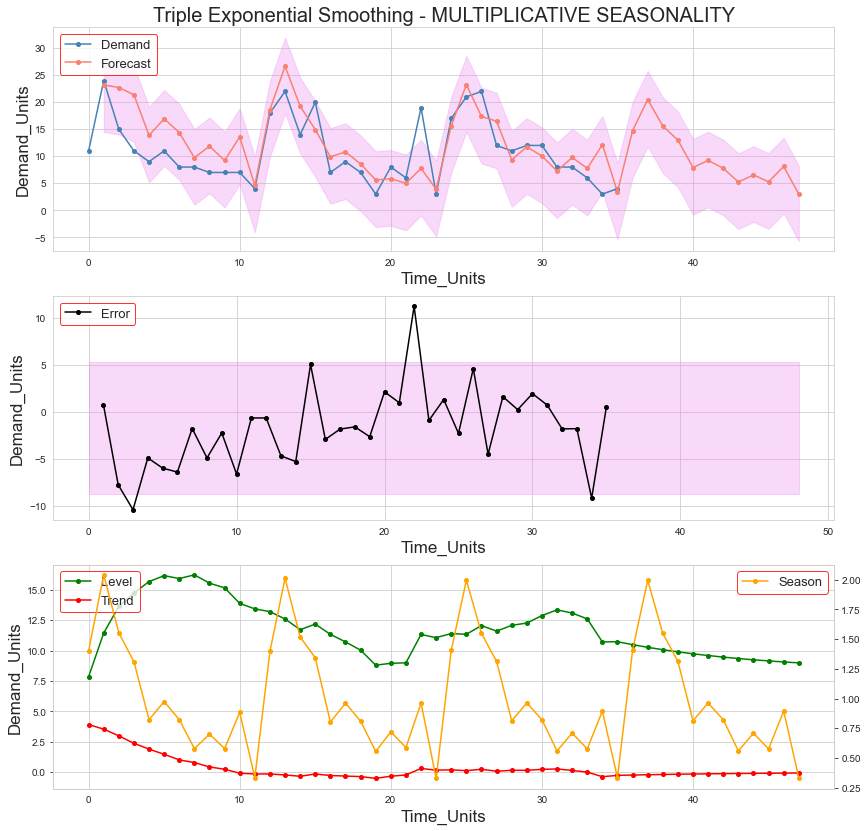

In [64]:
# Plot

fig, ax = plt.subplots(3, figsize = (14, 14))

ax[0].plot(df['Demand'], color = 'steelblue', label = 'Demand', marker = '.', markersize = 8)
ax[0].plot(df['Forecast'], color = 'salmon', label = 'Forecast', marker = '.', markersize = 8)
ax[0].fill_between(df.index, df['Forecast'] + lower_limit_error, df['Forecast'] + upper_limit_error, 
                   color='violet', alpha = 0.3)

ax[1].plot(df['Error'], color = 'black', label = 'Error', marker = '.', markersize = 8)
ax[1].fill_between([0, len(df['Error'])], lower_limit_error, upper_limit_error, color='violet', alpha = 0.3)

ax[2].plot(df['Level'], color = 'green', label = 'Level', marker = '.', markersize = 8)
ax[2].plot(df['Trend'], color = 'red', label = 'Trend', marker = '.', markersize = 8)
ax2 = ax[2].twinx()
ax2.grid(False)
ax2.plot(df['Season'], color = 'orange', label = 'Season', marker = '.', markersize = 8)


ax[0].set_xlabel('Time_Units', fontsize = 17)
ax[1].set_xlabel('Time_Units', fontsize = 17)
ax[2].set_xlabel('Time_Units', fontsize = 17)
ax[0].set_ylabel('Demand_Units', fontsize = 17)
ax[1].set_ylabel('Demand_Units', fontsize = 17)
ax[2].set_ylabel('Demand_Units', fontsize = 17)

ax[0].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')
ax[1].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')
ax[2].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')
ax2.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper right')


ax[0].set_title('Triple Exponential Smoothing - MULTIPLICATIVE SEASONALITY', fontsize = 20)

plt.show()

In [65]:
df['Updated'] = df['Demand'].clip(lower = df['Forecast'] + lower_limit_error, 
                                  upper = df['Forecast'] + upper_limit_error)

df

Demand   Forecast      Level     Trend    Season      Error    Updated
0     11.0        NaN   7.851449  3.909745  1.401015        NaN  11.000000
1     24.0  23.202174  11.448414  3.534409  2.040609   0.797826  24.000000
2     15.0  22.723813  13.634879  2.982068  1.553299  -7.723813  15.000000
3     11.0  21.371750  14.734837  2.367080  1.309645 -10.371750  12.667868
4      9.0  13.868852  15.681056  1.893542  0.822335  -4.868852   9.000000
5     11.0  16.943994  16.165486  1.460236  0.974619  -5.943994  11.000000
6      8.0  14.374169  15.929438  1.004160  0.822335  -6.374169   8.000000
7      8.0   9.741029  16.231458  0.783399  0.578680  -1.741029   8.000000
8      7.0  11.864160  15.547765  0.427309  0.700508  -4.864160   7.000000
9      7.0   9.219731  15.165173  0.231144  0.578680  -2.219731   7.000000
10     7.0  13.578361  13.883619 -0.089887  0.883249  -6.578361   7.000000
11     4.0   4.624262  13.430055 -0.155431  0.335025  -0.624262   4.000000
12    18.0  18.619727  13.201699 -0.157582  1.397260  -0.619727  18.000000
13    22.0  26.650101  12.604119 -0.232975  2.011094  -4.650101  22.000000
14    14.0  19.252280  11.718168 -0.344932  1.517442  -5.252280  14.000000
15    20.0  14.940071  12.180447 -0.155895  1.342878   5.059929  20.000000
16     7.0   9.901029  11.334582 -0.281418  0.801859  -2.901029   7.000000
17     9.0  10.800054  10.711920 -0.327153  0.961176  -1.800054   9.000000
18     7.0   8.566660  10.036455 -0.370643  0.809847  -1.566660   7.000000
19     3.0   5.614862   8.799143 -0.514326  0.554906  -2.614862   3.000000
20     8.0   5.839606   8.953058 -0.339531  0.719812   2.160394   8.000000
21     6.0   5.004125   8.991668 -0.236741  0.587541   0.995875   6.000000
22    19.0   7.753688  11.325180  0.296249  0.962692  11.246312  13.053046
23     3.0   3.883549  11.064352  0.161134  0.328637  -0.883549   3.000000
24    17.0  15.662406  11.400832  0.183312  1.406646   1.337594  17.000000
25    21.0  23.259942  11.341066  0.120032  1.995153  -2.259942  21.000000
26    22.0  17.373339  12.058892  0.229988  1.548136   4.626661  22.000000
27    12.0  16.471580  11.599912  0.073795  1.312039  -4.471580  12.000000
28    11.0   9.354755  12.076685  0.148487  0.812758   1.645245  11.000000
29    12.0  11.736269  12.265200  0.144614  0.962896   0.263731  12.000000
30    12.0  10.038343  12.879804  0.227043  0.822032   1.961657  12.000000
31     8.0   7.260475  13.350683  0.257647  0.559338   0.739525   8.000000
32     8.0   9.776891  13.088855  0.133140  0.708951  -1.776891   8.000000
33     6.0   7.760637  12.609357 -0.000039  0.576370  -1.760637   6.000000
34     3.0  12.138888  10.710710 -0.379757  0.894432  -9.138888   3.435006
35     4.0   3.407613  10.729440 -0.269679  0.333054   0.592387   4.000000
36     NaN  14.751112  10.486729 -0.242711  1.406646        NaN        NaN
37     NaN  20.486803  10.268288 -0.218440  1.995153        NaN        NaN
38     NaN  15.592348  10.071692 -0.196596  1.548136        NaN        NaN
39     NaN  12.982306   9.894756 -0.176937  1.312039        NaN        NaN
40     NaN   7.912617   9.735513 -0.159243  0.812758        NaN        NaN
41     NaN   9.236286   9.592194 -0.143319  0.962896        NaN        NaN
42     NaN   7.779056   9.463207 -0.128987  0.822032        NaN        NaN
43     NaN   5.228197   9.347119 -0.116088  0.559338        NaN        NaN
44     NaN   6.552582   9.242640 -0.104479  0.708951        NaN        NaN
45     NaN   5.272986   9.148608 -0.094031  0.576370        NaN        NaN
46     NaN   8.107112   9.063980 -0.084628  0.894432        NaN        NaN
47     NaN   2.993426   8.987815 -0.076165  0.333054        NaN        NaN

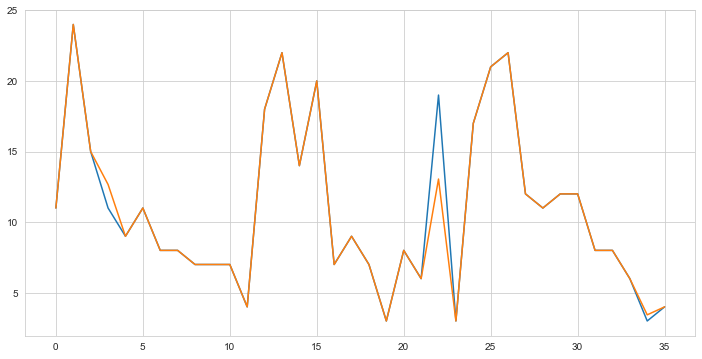

In [66]:
# Plot

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(df['Demand'])
ax.plot(df['Updated'])
plt.show()

# Triple Additive Exponential Smoothing

## Modello

Prendo la domanda dell'esempio sopra, per cui sappiamo che la stagionalità è di 4 periodi.

Per prima cosa creo una funzione, che a partire dalla stagionalità, mi crea $s_{0}$, ovvero il coefficiente di stagionalità moltiplicativa.

Poi creo la funzione vera e propria Triple_Exp_Smooth.

In [67]:
d = [14, 10, 6, 2, 18, 8, 4, 1, 16, 9, 5, 3, 18, 11, 4, 2, 17, 9, 5, 1]

In [68]:
# s è un array che passo come argomento
# s_len è la lunghezza della stagione, ovvero p, quanti periodi servono per far iniziare e terminare la stagione

def seasonal_factor_add(d, s, s_len, k):
    
    for j in range(0, s_len):
        s[j] = np.mean(d[j: k: s_len]) # media di j, j+s_len, j+2*s_len, ... fino al termine della domanda, ovvero k
        print(f'Calcolato s[{j}] pari a {s[j]}, ma non è ancora relativizzato rispetto al periodo medio')
    
    # normalizzazione sottraendo dalle medie di ogni trimestre, il trimestre medio calcolato sui primi periodi
    s = s - np.mean(s[0:s_len]) # la somma dei primi s_len fattori di s deve essere proprio s_len
    for j in range(0, s_len):
        print(f'Calcolato il fattore stagionale s[{j}] = {round(s[j], 2)}')
    
    return(s)

#Esempio

s_esempio = np.full(len(d), np.nan)
s_esempio = seasonal_factor_add(d = d, s = s_esempio, s_len = 4, k = len(d))
s_esempio              

Calcolato s[0] pari a 16.6, ma non è ancora relativizzato rispetto al periodo medio
Calcolato s[1] pari a 9.4, ma non è ancora relativizzato rispetto al periodo medio
Calcolato s[2] pari a 4.8, ma non è ancora relativizzato rispetto al periodo medio
Calcolato s[3] pari a 1.8, ma non è ancora relativizzato rispetto al periodo medio
Calcolato il fattore stagionale s[0] = 8.45
Calcolato il fattore stagionale s[1] = 1.25
Calcolato il fattore stagionale s[2] = -3.35
Calcolato il fattore stagionale s[3] = -6.35


array([ 8.45,  1.25, -3.35, -6.35,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan])

In [69]:
def Triple_Exp_Smooth_Damped_Add(d, s_len = 12, extra_periods = 5,  alpha = 0.4, beta = 0.4, phi = 0.9, gamma = 0.3):
    
    k = len(d)
    
    #Creo gli array
    d = np.append(d, [np.nan]*extra_periods) #Demand
    f = np.full(k + extra_periods, np.nan) #Forecast
    a = np.full(k + extra_periods, np.nan) #Level
    b = np.full(k + extra_periods, np.nan) #Trend
    s = np.full(k + extra_periods, np.nan) #Seasonal factor
    
    # Inizializzo la stagionalità col metodo sopra visto
    s = seasonal_factor_add(d = d, s = s, s_len = s_len, k = k)
    
    #Inizializzo livello e trend
    a[0] = d[0] - s[0]
    b[0] = (d[1]-s[1]) - (d[0]-s[0]) # data leakage
    print('Coefficienti computati con inizializzazione semplice:')
    print(f'a[0] = d[0] - s[0] = {a[0]} \nb[0] = (d[1] - s[1])  - (d[0] - s[0]) = {b[0]}')
    
    
    #Creo la forecast per la prima stagione per cui ho calcolato i coefficienti s
    for t in range(1, s_len):
        f[t] = a[t-1] + phi*b[t-1] + s[t] # 1) Computo la forecast
        a[t] = alpha * (d[t]-s[t]) + (1-alpha)*(a[t-1] + phi*b[t-1]) # 2) Aggiusto il livello a[t] in base alla f[t] e d[t]
        b[t] = beta * (a[t] - a[t-1]) + (1-beta)*phi*b[t-1] # 3) Aggiusto il trend sulla base di a[t] appena aggiornato
    
    
    #Qui considero i coefficienti di stagionalità computati per la prima stagione
    for t in range(s_len, k):
        f[t] = a[t-1] + phi*b[t-1] + s[t-s_len] # 1) Computo la forecast 
        a[t] = alpha * (d[t]-s[t-s_len]) + (1-alpha)*(a[t-1] + phi*b[t-1]) # 2) Aggiusto il livello a[t]
        b[t] = beta * (a[t] - a[t-1]) + (1-beta)*phi*b[t-1] # 3) Aggiusto il trend
        s[t] = gamma * (d[t]-a[t]) + (1-gamma)*s[t-s_len] # 4) Aggiusto la stagionalità
    
    
    for t in range(k, k + extra_periods):
        f[t] = a[t-1] + phi*b[t-1] + s[t-s_len] # 1) Computo la forecast
        a[t] = f[t] - s[t-s_len] # 2) Il livello equivale alla forecast e cresce di ogni periodo di un valore pari al trend b[t]
        b[t] = phi*b[t-1] # 3) Il trend è smorzato esponenzialmente
        s[t] = s[t-s_len] # 4) La stagionalità è quella dell'ultima stagione computata
        
    #Creo df
    df = pd.DataFrame({'Demand': d,
                       'Forecast':f,
                       'Level': a,
                       'Trend': b,
                       'Season': s, 
                       'Error': d-f})
    
    return(df)

In [70]:
df = Triple_Exp_Smooth_Damped_Add(d, s_len = 4, extra_periods = 4, alpha = 0.4, beta = 0.4, phi = 0.9, gamma = 0.3)
df

Calcolato s[0] pari a 16.6, ma non è ancora relativizzato rispetto al periodo medio
Calcolato s[1] pari a 9.4, ma non è ancora relativizzato rispetto al periodo medio
Calcolato s[2] pari a 4.8, ma non è ancora relativizzato rispetto al periodo medio
Calcolato s[3] pari a 1.8, ma non è ancora relativizzato rispetto al periodo medio
Calcolato il fattore stagionale s[0] = 8.45
Calcolato il fattore stagionale s[1] = 1.25
Calcolato il fattore stagionale s[2] = -3.35
Calcolato il fattore stagionale s[3] = -6.35
Coefficienti computati con inizializzazione semplice:
a[0] = d[0] - s[0] = 5.549999999999999 
b[0] = (d[1] - s[1])  - (d[0] - s[0]) = 3.200000000000001


Demand   Forecast      Level     Trend    Season     Error
0     14.0        NaN   5.550000  3.200000  8.450000       NaN
1     10.0   9.680000   8.558000  2.931200  1.250000  0.320000
2      6.0   7.846080  10.457648  2.342707 -3.350000 -1.846080
3      2.0   6.216084  10.879651  1.433863 -6.350000 -4.216084
4     18.0  20.620127  11.122076  0.871256  7.978377 -2.620127
5      8.0  13.156207   9.843724 -0.040862  0.321883 -5.156207
6      4.0   6.456948   8.824169 -0.429888 -3.792251 -2.456948
7      1.0   2.087270   8.002362 -0.560862 -6.545709 -1.087270
8     16.0  15.475963   7.707201 -0.420930  8.072704  0.524037
9      9.0   7.650246   7.868265 -0.162876  0.564838  1.349754
10     5.0   3.929426   8.149906  0.024703 -3.599547  1.070574
11     3.0   1.626430   8.721567  0.242004 -6.298466  1.373570
12    18.0  17.012074   9.334541  0.375872  8.250530  0.987926
13    11.0  10.237664   9.977760  0.460258  0.702059  0.762336
14     4.0   6.792445   9.275014 -0.032559 -4.102187 -2.792445
15     2.0   2.947245   8.866813 -0.180862 -6.468970 -0.947245
16    17.0  16.954568   8.722210 -0.155507  8.258708  0.045432
17     9.0   9.284313   8.468529 -0.185446  0.650883 -0.284313
18     5.0   4.199440   8.621851 -0.038812 -3.958087  0.800560
19     1.0   2.117950   8.139740 -0.213803 -6.670201 -1.117950
20     NaN  16.206026   7.947318 -0.192423  8.258708       NaN
21     NaN   8.425020   7.774138 -0.173180  0.650883       NaN
22     NaN   3.660189   7.618275 -0.155862 -3.958087       NaN
23     NaN   0.807798   7.477999 -0.140276 -6.670201       NaN

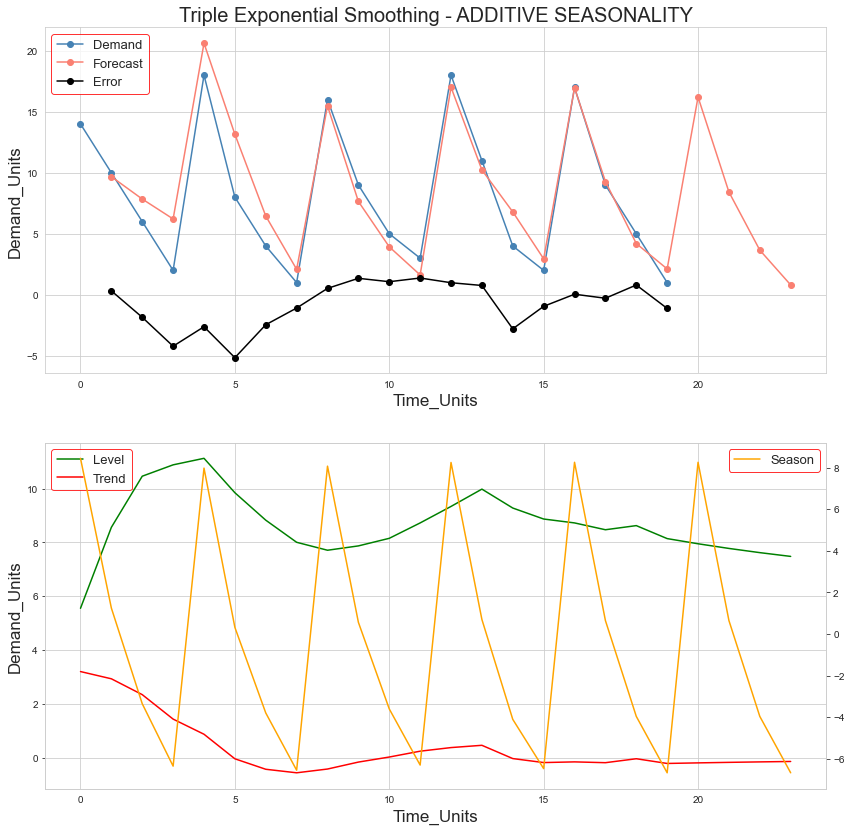

In [71]:
# Plot

fig, ax = plt.subplots(2, figsize = (14, 14))

ax[0].plot(df['Demand'], marker = 'o', color = 'steelblue', label = 'Demand')
ax[0].plot(df['Forecast'], marker = 'o', color = 'salmon', label = 'Forecast')
ax[0].plot(df['Error'], marker = 'o', color = 'black', label = 'Error')

ax[1].plot(df['Level'], color = 'green', label = 'Level')
ax[1].plot(df['Trend'], color = 'red', label = 'Trend')
ax2 = ax[1].twinx()
ax2.grid(False)
ax2.plot(df['Season'], color = 'orange', label = 'Season')


ax[0].set_xlabel('Time_Units', fontsize = 17)
ax[1].set_xlabel('Time_Units', fontsize = 17)
ax[0].set_ylabel('Demand_Units', fontsize = 17)
ax[1].set_ylabel('Demand_Units', fontsize = 17)

ax[0].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')
ax[1].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper left')
ax2.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'upper right')

ax[0].set_title('Triple Exponential Smoothing - ADDITIVE SEASONALITY', fontsize = 20)

plt.show()